In [ ]:
%pylab inline

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches


from collections import defaultdict, Counter, OrderedDict

import cytograph as cg
import loompy
import palettable

sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
from scbeta_scrnaseq import utils
from scbeta_scrnaseq import vis
import scbeta_scrnaseq.cytograph_inmem_utils as cgm
import scbeta_scrnaseq.cytograph_analyses as cga

import scbeta_scrnaseq.figure_vis as fv

from sklearn.neighbors import RadiusNeighborsRegressor, KernelDensity


from scbeta_scrnaseq.figure_vis import core_colors
fv.setup_matplotlib_params()

mm_per_inch = 25.4

Populating the interactive namespace from numpy and matplotlib


In [ ]:
fv.setup_matplotlib_params()

In [3]:
importlib.reload(fv)

<module 'scbeta_scrnaseq.figure_vis' from '/Users/averes/Projects/Melton/Papers/Mapping_SCbeta/2019_02_04_final_version/code/scbeta_scrnaseq/figure_vis.py'>

In [4]:
import glob
pb_tpm = {}
for pbf in glob.glob('../*/data/complete_processing/*.pseudobulk_tpm.df.npz'):
    key = os.path.basename(pbf)[:-(len('.pseudobulk_tpm.df.npz'))]
    pb_tpm[key] = utils.load_df(pbf)
    
pb_expr = {}
for pbf in glob.glob('../*/data/complete_processing/*.expr_frac.df.npz'):
    key = os.path.basename(pbf)[:-(len('.expr_frac.df.npz'))]
    pb_expr[key] = utils.load_df(pbf)

In [6]:
ds = loompy.connect('../03_Stage_5/data/complete_processing/stage5.processed.loom')
ds.vals = sp.sparse.csr_matrix(ds.layers[""][:, :])


In [28]:
scb_ec_br_ds = loompy.connect('../03_Stage_5/data/pseudotime/stage5.scbeta_ec_neurog3_prog.loom')
d0_ds = loompy.connect('../03_Stage_5/data/pseudotime/stage5.day0.loom')
d1_ds = loompy.connect('../03_Stage_5/data/pseudotime/stage5.day1.loom')


In [29]:
utils.preload_ds_vals(scb_ec_br_ds)
utils.preload_ds_vals(d0_ds)
utils.preload_ds_vals(d1_ds)

In [30]:
scb_ec_br_ds.shape, d0_ds.shape, d1_ds.shape

((16224, 18099), (16224, 5131), (16224, 5109))

In [31]:
tsne_proj = ds.ca['TSNE']

# tSNE -- labelled by day

In [32]:
label_order = ['scbeta', 'ph', 'ec',
               'neurog3_late', 'neurog3_mid', 'neurog3_early', 
               'fev_high_isl_low',  'phox2a',
               'sst_hhex', 'exo', 'prog_nkx61']
# ratio_order = ['scbeta', 'ph', 'ec', 'neurog3', 'sst',  'exo', 'other', 'repl']

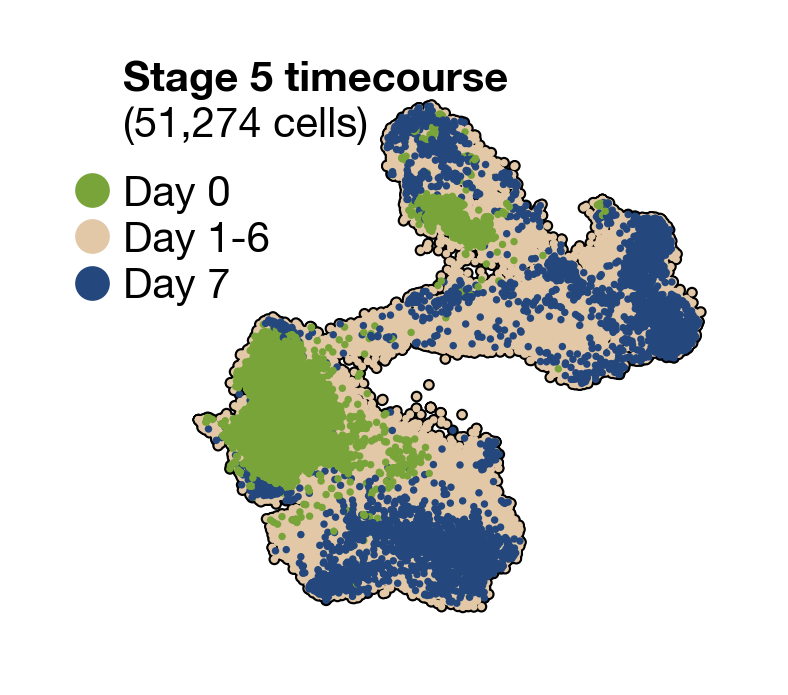

In [33]:
importlib.reload(fv)# _ds = tds[s]
# tsne_proj = ds.ca['TSNE']
cell_clusters = ds.ca['Labels']
cell_day = ds.ca["CellDay"]
label_params = fv.dataset_label_params('stage6')
    
display_s = 0.8
outline_s = 2.0
    
width_ratios=[0.3, 1.5]
height_ratios=[0.1, 1.5]

fig_h = (25/mm_per_inch) 
fig_w = fig_h * (sum(width_ratios)/sum(height_ratios))
    
fig = plt.figure(figsize=(fig_w, fig_h), dpi=600)


gs = gridspec.GridSpec(len(height_ratios),len(width_ratios),  fig, 0,0,1,1, hspace=0, wspace=0,
                       width_ratios=width_ratios,
                       height_ratios=height_ratios)

###### Draw the labels
# 
#
    
ax = fig.add_subplot(gs[1, 0], xticks=[], yticks=[], xlim=[0,1], ylim=[0,1],
          xscale='linear', yscale='linear',
          frameon=False)
ax.set_xlim([0,width_ratios[0]/0.5])
ax.set_ylim([0,height_ratios[0]/0.1])
ax.set_xticks([])
ax.set_yticks([])

li = 0
yl_pos = lambda lii: 1 - lii/12
xl_ = 0.14
xl_pos_dot = xl_ + 0.02
xl_pos_text = xl_ + 0.19
xl_pos_label = xl_ + 0.19

ax.text(xl_pos_text, yl_pos(li), 'Stage 5 timecourse', verticalalignment='center', fontsize=5,
        fontdict=dict(weight='bold'),
        clip_on=False)
li += 1

ax.text(xl_pos_text, yl_pos(li), '(%s cells)'%format(len(tsne_proj),',d'), verticalalignment='center', fontsize=5,
        clip_on=False)
li += 1.5

cdict = {
    '0' : fv.to_array_col(palettable.wesanderson.Royal1_4.colors[0]).reshape(1,-1),
    '1-6' : fv.to_array_col(palettable.wesanderson.FantasticFox1_5.colors[-1]).reshape(1,-1),
    '7' : fv.to_array_col(palettable.wesanderson.Darjeeling3_5.colors[-2]).reshape(1,-1),
}

day_params = defaultdict(lambda: dict(color=fv.to_array_col(palettable.wesanderson.FantasticFox1_5.colors[-1]).reshape(1,-1)), {
    0 : dict(color=fv.to_array_col(palettable.wesanderson.Royal1_4.colors[0]).reshape(1,-1)),
    7 : dict(color=fv.to_array_col(palettable.wesanderson.Darjeeling3_5.colors[-2]).reshape(1,-1)),
})

for label_i in [0, '1-6', 7]:
    ax.scatter(xl_pos_dot, yl_pos(li)+0.008, c=day_params[label_i]['color'], s=10,
               clip_on=False, vmin=0, vmax=8)
    ax.text(xl_pos_label, yl_pos(li), 'Day %s'%label_i, verticalalignment='center', fontsize=5, clip_on=False)
    li += 1


###### Scatter plot
# 
#

_proj, _c = fv.prepare_for_scatter(tsne_proj, cell_day, day_params) 

ax = fig.add_subplot(gs[1, 1], xticks=[], yticks=[],
              xscale='linear', yscale='linear',
              frameon=False,  zorder=-1)
ax.patch.set_visible(False)

s_black, s_white, s_type = 2, 0.8, 0.8
ax.scatter(_proj[:, 0], _proj[:, 1], c='k', edgecolor='none', s=s_black, 
               rasterized=True)
ax.scatter(_proj[:, 0], _proj[:, 1], c=_c, edgecolor='none', s=s_type, alpha=1.0,
               rasterized=True)


# Place the tSNE further to the top, right
old_xlim = np.array(ax.get_xlim())
old_ylim = np.array(ax.get_ylim())
shift_amt = 0.2
x_span = old_xlim[1]-old_xlim[0]
y_span = old_ylim[1]-old_ylim[0]
xlim = np.array([old_xlim[0] - shift_amt*(x_span), old_xlim[1]])
ylim = np.array([old_ylim[0] - shift_amt*(y_span)*0.2, old_ylim[1] + shift_amt*(y_span)*0.8])
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)


fig.savefig('../../figures/components/main_figure5/TSNE_day_by_day.pdf', dpi=600, transparent=True)


# tSNE labeled by NEUROG3

In [12]:
tpm_normalizer = cgm.CountsNormalizer(normalize_variance=False, mean_center=False)
tpm_normalizer.fit(ds.vals)

tpm_z_normalizer = cgm.CountsNormalizer()
tpm_z_normalizer.fit(ds.vals)

In [15]:
genes = ['NEUROG3', 'INS', 'GCG', 'TPH1', 'NKX6-1', 'ISL1', 'LMX1A', 'SOX2', 'CDX2']

regressed_expr_values = {}


for g in genes:
    
    gi = np.where(ds.ra.Gene==g)[0]
    expr_values = tpm_normalizer.transform(ds.vals, genes=gi).T

    reg = fv.proj_regressor(tsne_proj, expr_values, radius=1)
    pred_values = reg.predict(tsne_proj).ravel()
    
    pred_values = pred_values/np.percentile(pred_values, 98)
    pred_values = np.log10(pred_values + 0.01)
    regressed_expr_values[g] = pred_values
    


In [14]:
# ds.close()

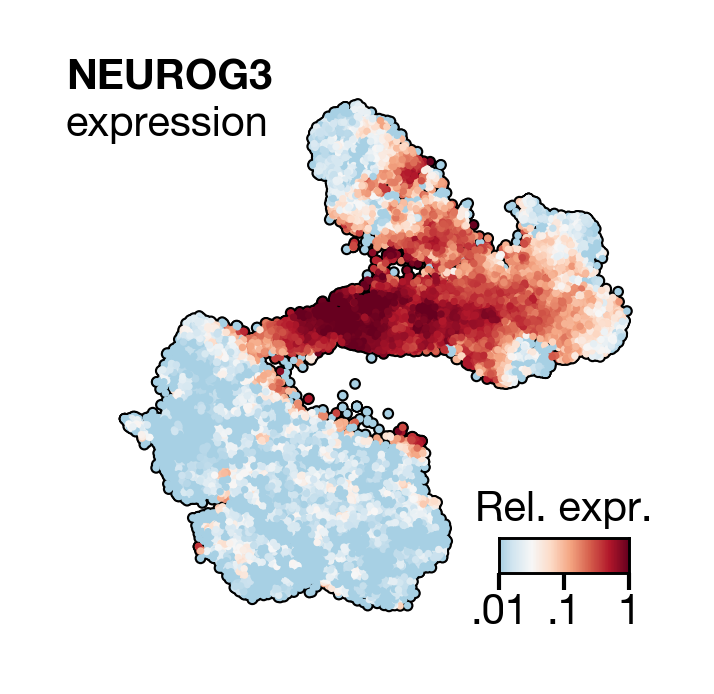

In [24]:
importlib.reload(fv)# _ds = tds[s]
# tsne_proj = ds.ca['TSNE']
cell_clusters = ds.ca['Labels']
cell_day = ds.ca["CellDay"]
label_params = fv.dataset_label_params('stage6')
    
display_s = 0.8
outline_s = 2
    
g = 'NEUROG3'
vmin, vmax = -3, 0


width_ratios=[0.1, 1.5]
height_ratios=[0.1, 1.5]

fig_h = (25/mm_per_inch) 
fig_w = fig_h * (sum(width_ratios)/sum(height_ratios))
    
fig = plt.figure(figsize=(fig_w, fig_h), dpi=600)

gs = gridspec.GridSpec(len(height_ratios),len(width_ratios),  fig, 0,0,1,1, hspace=0, wspace=0,
                       width_ratios=width_ratios,
                       height_ratios=height_ratios)


###### Draw the labels
# 
#
    
ax = fig.add_subplot(gs[1, 0], xticks=[], yticks=[], xlim=[0,1], ylim=[0,1],
          xscale='linear', yscale='linear',
          frameon=False)
ax.set_xlim([0,width_ratios[0]/0.5])
ax.set_ylim([0,height_ratios[0]/0.1])
ax.set_xticks([])
ax.set_yticks([])

li = 0
yl_pos = lambda lii: 1 - lii/12
xl_pos_dot = 0.15
xl_pos_text = 0.02

ax.text(xl_pos_text, yl_pos(li), g, verticalalignment='center', fontsize=5,
        fontdict=dict(weight='bold'),
        clip_on=False)
li += 1

ax.text(xl_pos_text, yl_pos(li), 'expression', verticalalignment='center', fontsize=5,
        clip_on=False)
li += 1.5

###### Scatter plot
# 
#

ax = fig.add_subplot(gs[1, 1], xticks=[], yticks=[],
              xscale='linear', yscale='linear',
              frameon=False,  zorder=-1)

ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c='k', edgecolor='none',
           s=outline_s, cmap='RdBu_r',
           rasterized=True)

imax = ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c=regressed_expr_values[g], edgecolor='none',
           s=display_s, cmap='RdBu_r', vmin=vmin, vmax=vmax,
           rasterized=True)
ax.patch.set_visible(False)

##### Draw the labels
# 
#

cvmin = -2
cvmax = 0


with plt.rc_context(fv.thin_legend_params):
    colorbar_ax_position = [0.04, 0.70, 0.22, 0.03]
    colorbar_ax_position = [0.74, 0.10, 0.22, 0.06]
    colorbar_ax = fig.add_axes(colorbar_ax_position,
                    xscale='linear', yscale='linear', yticks=[],
                    xlabel='', ylabel='', frameon=True, )

    gradient = np.linspace(cvmin, cvmax, 256)
    gradient = np.vstack((gradient, gradient))
    colorbar_ax.imshow(gradient, aspect='auto', extent=(cvmin,cvmax,0,1), 
                cmap=imax.cmap, vmin=vmin, vmax=vmax)
    colorbar_ax.tick_params(axis='both', which='major', pad=0.5, width=0.5, zorder=-10, length=2)

    xticks = np.linspace(cvmin, cvmax, 5).astype(int)
    colorbar_ax.set_xticks([-2, -1, 0])
    colorbar_ax.set_xticklabels(['.01', '.1', '1'], fontsize=5);

    colorbar_ax.set_title('Rel. expr.', fontsize=5, pad=2);


fig.savefig('../../figures/components/main_figure5/TSNE_Neurog3.pdf', dpi=600, transparent=True)


# tSNE -- cell label

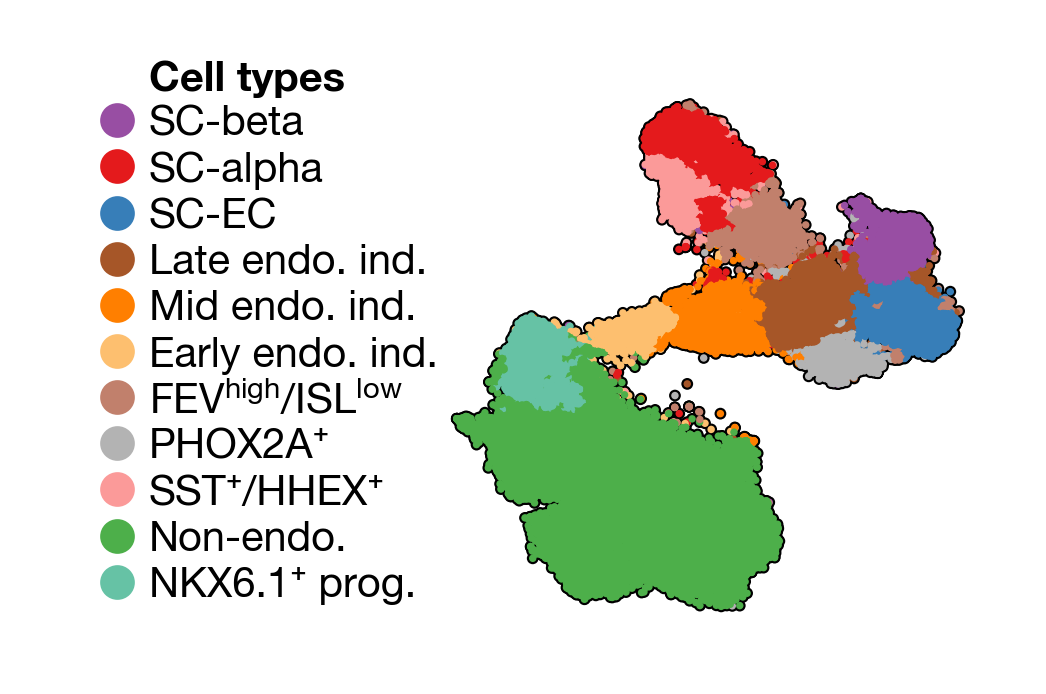

In [19]:
importlib.reload(fv)# _ds = tds[s]
# tsne_proj = ds.ca['TSNE']
cell_clusters = ds.ca['Labels']
cell_day = ds.ca["CellDay"]
label_params = fv.dataset_label_params('stage5')
    

width_ratios=[1.0, 1.5]
height_ratios=[0.1, 1.5]

fig_h = (25/mm_per_inch) 
fig_w = fig_h * (sum(width_ratios)/sum(height_ratios))
    
fig = plt.figure(figsize=(fig_w, fig_h), dpi=600)

gs = gridspec.GridSpec(len(height_ratios),len(width_ratios),  fig, 0,0,1,1, hspace=0, wspace=0,
                       width_ratios=width_ratios,
                       height_ratios=height_ratios)

###### Draw the labels
# 
#
    
ax = fig.add_subplot(gs[1, 0], xticks=[], yticks=[], xlim=[0,1], ylim=[0,1],
          xscale='linear', yscale='linear',
          frameon=False)
ax.set_xlim([0,width_ratios[0]/0.5])
ax.set_ylim([0,height_ratios[0]/0.1])
ax.set_xticks([])
ax.set_yticks([])

li = 0
yl_pos = lambda lii: 1 - lii/12
xl_ = 0.28
xl_pos_dot = xl_ + 0.02
xl_pos_text = xl_ + 0.19
xl_pos_label = xl_ + 0.19

ax.text(xl_pos_text, yl_pos(li), 'Cell types', verticalalignment='center', fontsize=5,
        fontdict=dict(weight='bold'),
        clip_on=False)
li += 1

# ax.text(xl_pos_text, yl_pos(li), '(%d cells)'%len(tsne_proj), verticalalignment='center', fontsize=7,
#         clip_on=False)
# li += 1.5

_present_labels = set(cell_clusters)
for lb in [lb for lb in label_order if lb in _present_labels]:
    lb_text = label_params[lb]['short_label']
    ax.scatter(xl_pos_dot, yl_pos(li)+0.0075, s=10, clip_on=False, c=label_params[lb]['color'].reshape(1,-1))
    for leg_label_line in lb_text.splitlines():            
        ax.text(xl_pos_label, yl_pos(li), leg_label_line, verticalalignment='center', fontsize=5,clip_on=False)
        li += 1

###### Scatter plot
# 
#

_proj, _c = fv.prepare_for_scatter(tsne_proj, cell_clusters, label_params) 

ax = fig.add_subplot(gs[1, 1], xticks=[], yticks=[],
              xscale='linear', yscale='linear',
              frameon=False,  zorder=-1)
ax.patch.set_visible(False)

ax.scatter(_proj[:, 0], _proj[:, 1], c='k', edgecolor='none', s=outline_s, 
               rasterized=True)

ax.scatter(_proj[:, 0], _proj[:, 1], c=_c, edgecolor='none', s=display_s, 
               rasterized=True)


fig.savefig('../../figures/components/main_figure5/TSNE_CellLabels.pdf', dpi=600, transparent=True)


# Population ratio bars

In [34]:
ds.ca['CellFlask'] = np.array([int(c[8]) for c in ds.ca.CellID])

In [35]:

cell_flask = ds.ca['CellFlask']
cell_day = ds.ca['CellDay']
cell_clusters = ds.ca['Labels']
label_params = fv.dataset_label_params('stage5')
    

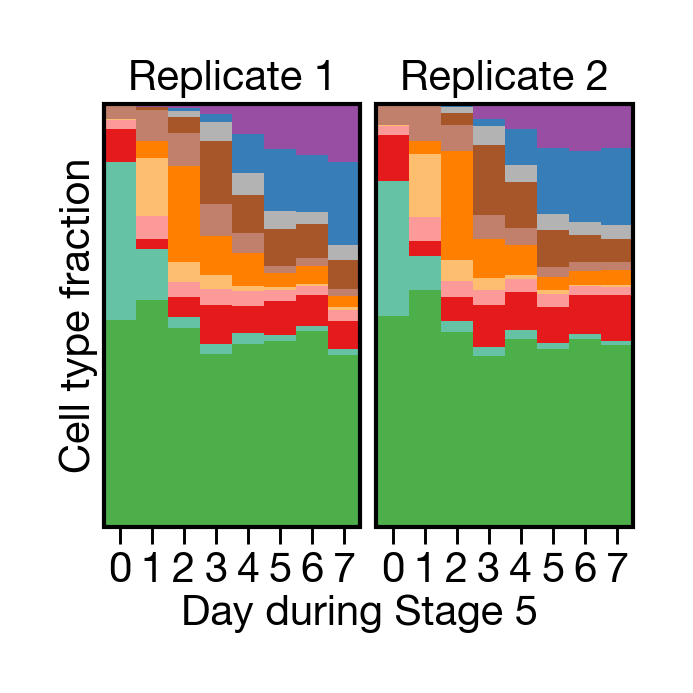

In [45]:
ratio_order = ['scbeta',  'ec', 'phox2a', 
               'neurog3_late', 'fev_high_isl_low', 'neurog3_mid', 'neurog3_early', 
               'sst_hhex', 'ph', 
               'prog_nkx61', 'exo', 'prog_sox2', ][::-1]

width_ratios=[1.7]
height_ratios=[1.6]

fig_h = (25/mm_per_inch) 
fig_w = fig_h * (sum(width_ratios)/sum(height_ratios))

fig = plt.figure(figsize=(fig_w, fig_h), dpi=600)

gs = gridspec.GridSpec(1, 1, fig, 0.13, 0.19, 0.95, 0.91, hspace=0.2, wspace=0)

with plt.rc_context(fv.thin_legend_params):
    ax = fig.add_subplot(gs[0],
                      xscale='linear', yscale='linear',
                      frameon=False)

    d = 0
    for f in (1,2):
        f_offset = 0 if f==2 else 8.5
        for d in range(8):

            d_filter = (cell_day==d) & (cell_flask==f)

            n_by_cluster = pd.Series(Counter(cell_clusters[d_filter]))
            n_by_cluster = n_by_cluster/n_by_cluster.sum()

            cumul_frac = 0
            for lb in ratio_order:
                if lb in n_by_cluster:
                    cl_frac = n_by_cluster[lb]
                    ax.add_patch(
                            patches.Rectangle(
                                (-0.5+d+f_offset, cumul_frac), 1, cl_frac,
                                facecolor=label_params[lb]['color'], edgecolor='none', clip_on=False,
                            ))
                    cumul_frac += cl_frac




        p = ax.add_patch(
            patches.Rectangle(
                (-0.5+f_offset, 0), 8, 0.995,
                facecolor='none', edgecolor='k', linewidth=0.5, zorder=10, clip_on=False,
            ))
    #     p.set_clipon(False)    
    ax.set_xlim(-0.53, -0.5+1+d+f_offset+0.02)
    ax.set_ylim(0, 1)

    ax.set_xticks(list(np.arange(8)) + list(np.arange(8)+8.5))
    ax.set_xticklabels(list(range(8))+list(range(8)))

    ax.set_yticks([])

    ax.set_xlabel('Day during Stage 5', labelpad=0.5)
    ax.set_ylabel('Cell type fraction', labelpad=0.5)

    ax.text(3.5, 1.01, 'Replicate 1', clip_on=False, ha='center', va='bottom', fontsize=rcParams['xtick.labelsize'] )
    ax.text(3.5 + 8.5, 1.01, 'Replicate 2', clip_on=False, ha='center', va='bottom', fontsize=rcParams['xtick.labelsize'] )

fig.savefig('../../figures/components/main_figure5/FlaskCellTypeRatios.pdf', dpi=600, transparent=True)


## Pseudotime -- on tSNE

In [36]:
pdt_ds = scb_ec_br_ds

pdt_cells = np.where(np.isin(ds.ca.CellID, list(pdt_ds.ca.CellID)))[0]

pdt_cells_index = ds.ca.CellID[pdt_cells]
pdt = pd.Series(pdt_ds.ca.PseudotimeRank, pdt_ds.ca.CellID)[pdt_cells_index].values


In [37]:

BlOr_map = palettable.palette.Palette(name='BlOr_9', map_type="",
                           colors=palettable.colorbrewer.diverging.PuOr_10.colors[:5] + palettable.colorbrewer.diverging.RdBu_10.colors[-5:]).get_mpl_colormap()
           
BlOr_map = palettable.palette.Palette(name='BlOr_9', map_type="",
                           colors=palettable.colorbrewer.diverging.PuOr_8.colors[:4] + palettable.colorbrewer.diverging.RdBu_8.colors[-4:]).get_mpl_colormap()
           
    
PuOr_map = palettable.colorbrewer.diverging.PuOr_8.get_mpl_colormap()

In [38]:
branch = pd.Series(pdt_ds.ca.PseudotimeBranch, pdt_ds.ca.CellID)[pdt_cells_index].values

In [39]:
sub_tsne_proj = tsne_proj[pdt_cells]
pdt_reg = fv.proj_regressor(sub_tsne_proj, pdt, radius=0.5)

In [40]:
pdt_reg_br0 = fv.proj_regressor(sub_tsne_proj[branch==0], pdt[branch==0], radius=0.5)
pdt_reg_br1 = fv.proj_regressor(sub_tsne_proj[branch==1], pdt[branch==1], radius=0.5)

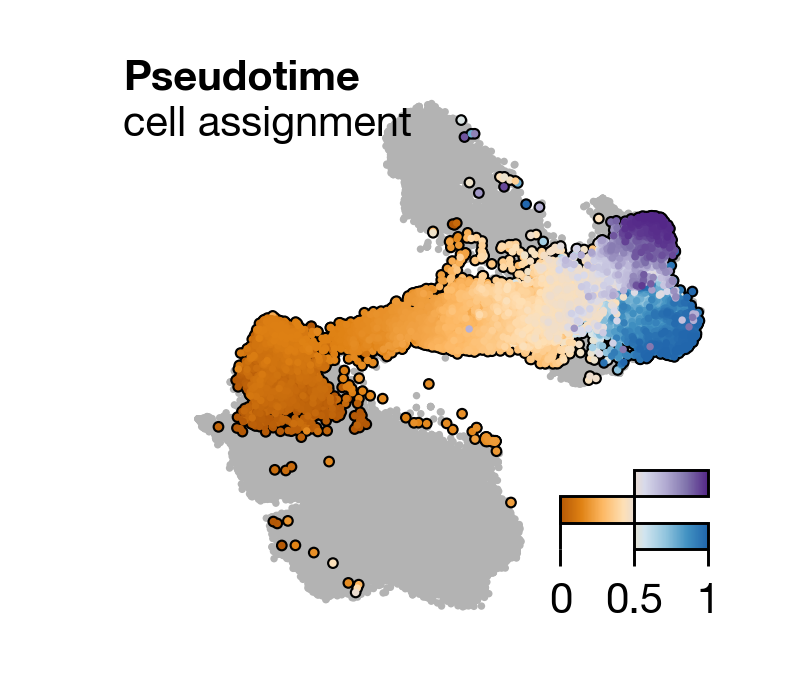

In [41]:
importlib.reload(fv)# _ds = tds[s]
# tsne_proj = ds.ca['TSNE']
cell_clusters = ds.ca['Labels']
cell_day = ds.ca["CellDay"]
label_params = fv.dataset_label_params('stage6')
    
display_s = 0.8
outline_s = 2.0
    
    

width_ratios=[0.3, 1.5, 0.2]
height_ratios=[0.1, 1.5]

fig_h = (25/mm_per_inch) 
fig_w = fig_h * (sum(width_ratios)/sum(height_ratios))

fig = plt.figure(figsize=(fig_w, fig_h), dpi=600)

gs = gridspec.GridSpec(len(height_ratios), len(width_ratios),  fig, 0,0,1,1, hspace=0, wspace=0,
                       width_ratios=width_ratios,
                       height_ratios=height_ratios)


###### Draw the labels
# 
#
    
ax = fig.add_subplot(gs[1, 0], xticks=[], yticks=[], xlim=[0,1], ylim=[0,1],
          xscale='linear', yscale='linear',
          frameon=False)
ax.set_xlim([0,width_ratios[0]/0.5])
ax.set_ylim([0,height_ratios[0]/0.1])
ax.set_xticks([])
ax.set_yticks([])

li = 0
yl_pos = lambda lii: 1 - lii/12
xl_ = 0.14
xl_pos_dot = xl_ + 0.07
xl_pos_text = xl_ + 0.19
xl_pos_label = xl_ + 0.19

ax.text(xl_pos_text, yl_pos(li), 'Pseudotime', verticalalignment='center', fontsize=5,
        fontdict=dict(weight='bold'),
        clip_on=False)
li += 1

ax.text(xl_pos_text, yl_pos(li), 'cell assignment', verticalalignment='center', fontsize=5,
        clip_on=False)
li += 1.5

###### Scatter plot
# 
#

ax = fig.add_subplot(gs[1, 1], xticks=[], yticks=[],
              xscale='linear', yscale='linear',
              frameon=False,  zorder=-1)

ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c=core_colors.light_grey.reshape(1,-1), edgecolor='none',
           s=0.8, 
           rasterized=True)

ax.scatter(sub_tsne_proj[:, 0], sub_tsne_proj[:, 1], c='k', edgecolor='none',
           s=2.0,
           rasterized=True)

co_ = np.argsort(pdt[branch==0])
im = ax.scatter(sub_tsne_proj[branch==0, 0][co_], sub_tsne_proj[branch==0, 1][co_],
#                 c=pdt_reg_br0.predict(sub_tsne_proj[branch==0]),
                c=pdt[branch==0][co_],
                edgecolor='none',
           s=0.8,
                cmap = BlOr_map,
#                 cmap = palettable.colorbrewer.diverging.PuOr_9.get_mpl_colormap(),
           vmin=0, vmax=1,
           rasterized=True)

co_ = np.argsort(pdt[branch==1])
im = ax.scatter(sub_tsne_proj[branch==1, 0][co_], sub_tsne_proj[branch==1, 1][co_],
#                 c=pdt_reg_br1.predict(sub_tsne_proj[branch==1]),
                edgecolor='none',
           s=0.8,
#                 cmap = BlOr9_map.get_mpl_colormap(),
                c=pdt[branch==1][co_],
                cmap = PuOr_map,
           vmin=0, vmax=1,
           rasterized=True)

colorbar_ax_position = [0.10, 0.65, 0.20, 0.15]


with plt.rc_context(fv.thin_legend_params):
    colorbar_ax_position = [0.675, 0.14, 0.20, 0.15]
    colorbar_ax = fig.add_axes(colorbar_ax_position,
                    xscale='linear', yscale='linear', xticks=[], yticks=[],
                    xlabel='', ylabel='', frameon=False, )

    prog_gr = np.linspace(0, 0.5, 128)
    prog_gr = np.vstack((prog_gr, prog_gr))
    colorbar_ax.imshow(prog_gr, aspect='auto', extent=(0,0.5,0.3,0.6), 
                cmap=PuOr_map, vmin=0, vmax=1)

    rect_args = dict(linewidth=0.35 ,edgecolor='k',facecolor='none', clip_on=False)
    colorbar_ax.add_patch(patches.Rectangle((0,0.3),0.5, 0.3, **rect_args))

    endo_gr = np.linspace(0.5, 1, 128)
    endo_gr = np.vstack((endo_gr, endo_gr))
    colorbar_ax.imshow(endo_gr, aspect='auto', extent=(0.5,1,0.6,0.9), 
                cmap=PuOr_map, vmin=0, vmax=1)

    colorbar_ax.add_patch(patches.Rectangle((0.5,0.),0.5, 0.3, **rect_args))

    endo_gr = endo_gr.copy()
    colorbar_ax.imshow(endo_gr, aspect='auto', extent=(0.5,1,0.0,0.3), 
                cmap=BlOr_map , vmin=0, vmax=1)

    colorbar_ax.add_patch(patches.Rectangle((0.5,0.6),0.5, 0.3, **rect_args))

    colorbar_ax.add_patch(patches.Rectangle((0.,0.),0., 0.6, **rect_args))


    # import matplotlib.lines as mlines
    # colorbar_ax.add_line(mlines.Line2D((0,0), (0, 0.9), lw=0.5, alpha=1))

    # colorbar_ax.plot([0, 0], [0, 0.9], 'k--', lw=0.5)
    colorbar_ax.set_xlim([0, 1])
    colorbar_ax.set_ylim([0, 1])

    colorbar_ax.xaxis.set_tick_params(size=2, pad=2)
    colorbar_ax.set_xticks([0, 0.5, 1])
    colorbar_ax.set_xticklabels([0, 0.5, "1"], fontsize=5)


fig.savefig('../../figures/components/main_figure5/tSNE_branching_pseudotime.pdf', dpi=600, transparent=True)


    

## Pseudotime -- model fitting

In [42]:
pdt_ds = scb_ec_br_ds

In [43]:
cell_br = pdt_ds.ca.PseudotimeBranch
cell_pdt = pdt_ds.ca.PseudotimeRank

In [44]:
from scbeta_scrnaseq import pseudotime

In [45]:
importlib.reload(pseudotime)
pseudotime.annotate_vgam_ds(pdt_ds, pv = 0.1, n_smooth=5)

_r = np.where(pdt_ds.ra['_Regressed'])[0]

time_var = pd.Series(pdt_ds.ra['Pred__pseudotime__log2fc__min_max'], index=pdt_ds.ra.Gene).fillna(.0)

time_fc = pd.Series(pdt_ds.ra['Pred__pseudotime__log2fc__start_end'], index=pdt_ds.ra.Gene).fillna(.0)
br_fc = -pd.Series(pdt_ds.ra['Pred__branch__log2fc'], index=pdt_ds.ra.Gene).fillna(.0)
br_qval = pd.Series(pdt_ds.ra['LRT_branch_qval'], index=pdt_ds.ra.Gene).fillna(1.0)


In [46]:

ec_genes = ['TPH1', 'MME', 'FEV', 'ADRA2A', 'SLC18A1', 'LMX1A', 'DDC', 'NEUROG3' ]
beta_genes = ['ISL1', 'ITGA1', 'HADH', 'DLK1', 'NEFM', 'ERO1B', 'PDX1', 'INS']
unbranched_genes = ['NKX6-1', 'PAX4', 'LMX1B', 'MNX1', 'RFX3']

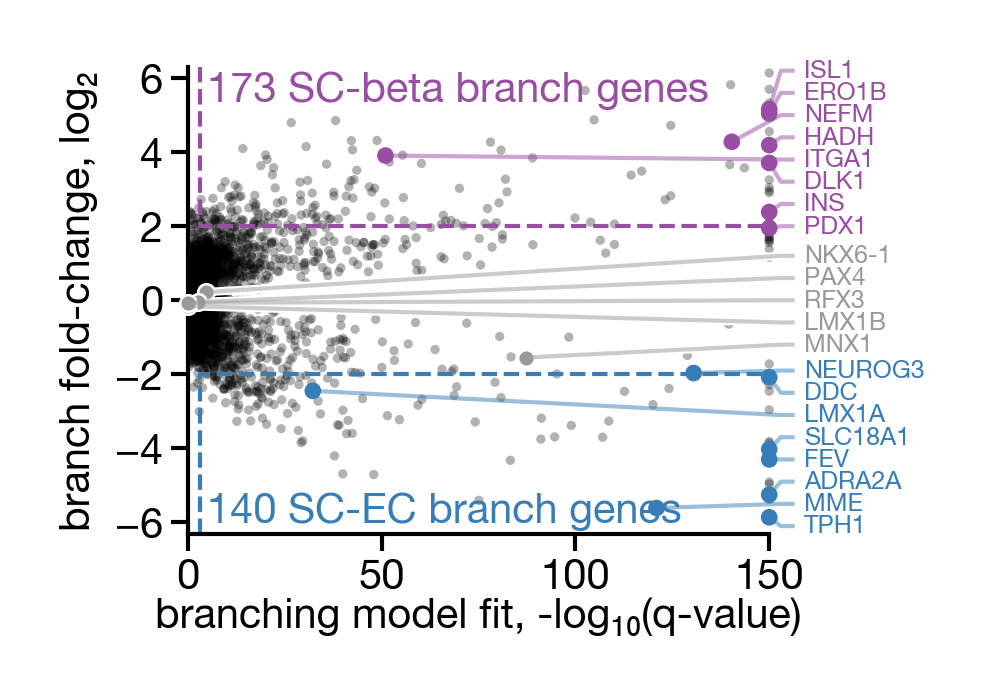

In [47]:
import matplotlib.patheffects as PathEffects

fig_h = (25/mm_per_inch) 
fig_w = fig_h * (2.5/1.6)

fig = plt.figure(figsize=(fig_w, fig_h), dpi=600)


# fig = plt.figure(figsize=(2.5, 1.6), dpi=600)

_reg = np.where(pdt_ds.ra['_Regressed'])[0]

gs = gridspec.GridSpec(1, 1, fig, 0.19, 0.18, 0.82,0.97,
                       hspace=0.1, wspace=0,
#                        width_ratios=[0.5, 2]+[0.1]*6,
#                        height_ratios=[1,2],
                      )

y = br_fc
x = -np.log10(br_qval + 10**-150)

# Draw the labels.
ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=True,
#             xticks=[], yticks=[],
                    )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# ax.tick_params(axis='both', which='major', pad=1, width=0.5, zorder=-10, length=2)
ax.set_xlabel(r'branching model fit, -log₁₀(q-value)', fontsize=5, labelpad=0)
ax.set_ylabel(r'branch fold-change, log₂', fontsize=5, labelpad=2)

clip__grp = (x > 90)
sc_attrs = dict(c='k', marker='.', edgecolor='none', s=5, alpha=0.3, rasterized=True)
ax.scatter(x[~clip__grp], y[~clip__grp], clip_on=True, **sc_attrs)
ax.scatter(x[clip__grp], y[clip__grp], clip_on=False, **sc_attrs)

gene_label_fontsize = 6


white_path_effect = [PathEffects.withStroke(linewidth=0.5, foreground='w')]
em_genes = beta_genes
em_col = core_colors.purple
g_label_spacing = 0.6

_ng = len(em_genes)
em_locs = 6.2 - (_ng - np.arange(_ng) - 1)*g_label_spacing

txt_pos = 106
line_pos = 104
notch_pos = 102
xlims = [0, 150]

txt_pos = 159
line_pos = 156
notch_pos = 153
xlims = [0, 150]


ax.scatter(x[em_genes],y[em_genes], color=em_col, edgecolor='none', s=4, clip_on=False)
for gi,g in enumerate(br_fc[em_genes].sort_values().index):
    g_loc = em_locs[gi]
    ax.text(txt_pos, g_loc, g, fontsize=3, ha='left', va='center', color=em_col)
    ax.plot([x[g], notch_pos, line_pos], [y[g], g_loc, g_loc], clip_on=False, lw=0.5, alpha=0.5, color=em_col)

    
em_genes = ec_genes
em_col = core_colors.blue
em_locs = np.linspace(-6.2, -1, 10)
_ng = len(em_genes)
em_locs = -6.1 + (np.arange(_ng))*g_label_spacing

ax.scatter(x[em_genes],y[em_genes], color=em_col, edgecolor='none', s=4, clip_on=False)
for gi,g in enumerate(br_fc[em_genes].sort_values().index):
    g_loc = em_locs[gi]
    ax.text(txt_pos, g_loc, g, fontsize=3, ha='left', va='center', color=em_col)
    ax.plot([x[g], notch_pos, line_pos], [y[g], g_loc, g_loc], clip_on=False, lw=0.5, alpha=0.5, color=em_col)

    
em_genes = unbranched_genes
em_col = core_colors.grey
em_locs = np.linspace(-3.1, 3.1, 10)
_ng = len(em_genes)
em_locs = 0 + (np.arange(_ng) - (_ng-1)/2)*g_label_spacing

ax.scatter(x[em_genes],y[em_genes], color=em_col, edgecolor='w', linewidth=0.3, s=4, clip_on=False, zorder=6)
for gi,g in enumerate(br_fc[em_genes].sort_values().index):
    g_loc = em_locs[gi]
    ax.plot([x[g], notch_pos, line_pos], [y[g], g_loc, g_loc], clip_on=False, lw=1, color='w', zorder=5)
    ax.plot([x[g], notch_pos, line_pos], [y[g], g_loc, g_loc], clip_on=False, lw=0.5, alpha=0.5, color=em_col, zorder=10)
    txt = ax.text(txt_pos, g_loc, g, fontsize=3, ha='left', va='center', color=em_col)
   
    
       
    
ylims = (-6.3, 6.3)

ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_yticks([-6,-4,-2,0,2,4,6])

qval_thr = 3
fc_thr = np.log2(4)
ax.plot([qval_thr, qval_thr, xlims[1]], [ylims[0], -fc_thr, -fc_thr], '--', linewidth=0.5, color=core_colors.blue)
ax.plot([qval_thr, qval_thr, xlims[1]], [ylims[1], fc_thr, fc_thr], '--', linewidth=0.5,color=core_colors.purple)

n_beta = sum((y > fc_thr) & (x > qval_thr))
n_ec = sum((y < -fc_thr) & (x > qval_thr))
ax.text(5, 6.2 , f'{n_beta} SC-beta branch genes', ha='left', va='top', fontsize=5, color=core_colors.purple)
ax.text(5, -6.2, f'{n_ec} SC-EC branch genes', ha='left', va='bottom', fontsize=5, color=core_colors.blue)

fig.savefig('../../figures/components/main_figure5/Branching_Fold_Changes.pdf', dpi=600, transparent=True)

In [48]:
pdt_norm = cgm.CountsNormalizer(normalize_variance=False, mean_center=False)
pdt_norm.fit(pdt_ds.vals)

In [49]:
cell_color = np.zeros((len(cell_br), 3))

for br, cm in [(0, BlOr_map), (1, PuOr_map)]:
    
    cell_color[cell_br==br, :] = cm(cell_pdt[cell_br==br])[:, :3]


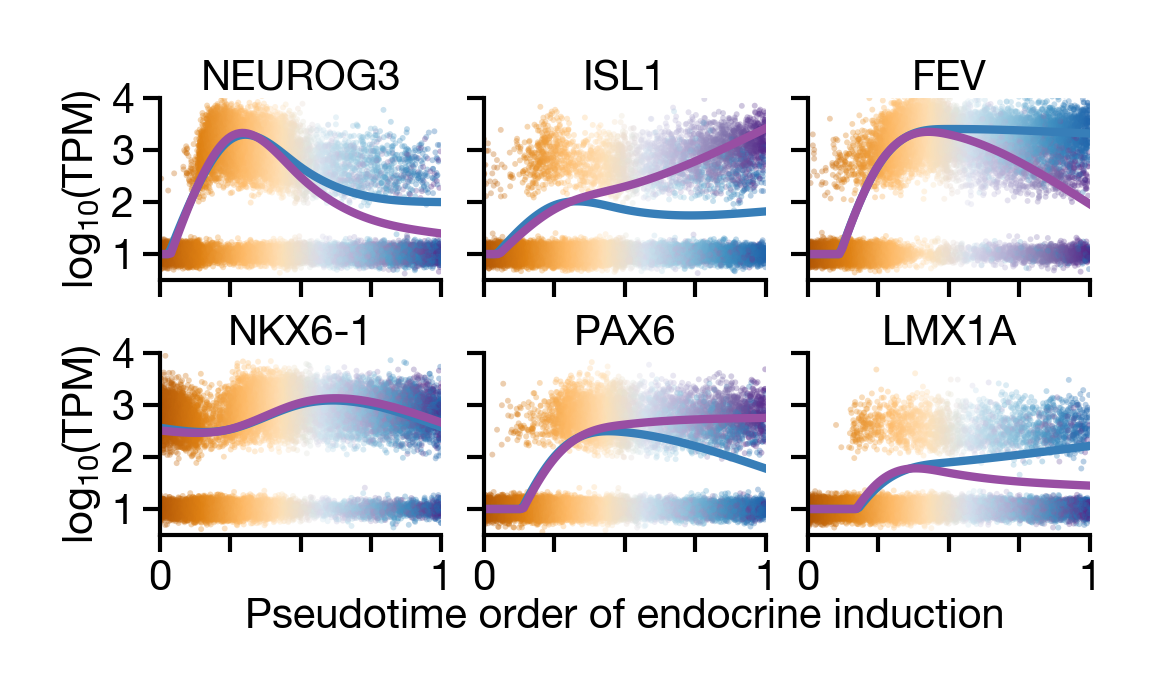

In [54]:

fig_h = (25/mm_per_inch) 
fig_w = fig_h * (3/1.6)

fig = plt.figure(figsize=(fig_w, fig_h), dpi=600)


gs = gridspec.GridSpec(2, 3, fig, 0.14, 0.18, 0.98, 0.92,
                       hspace=0.4, wspace=0.15,
#                        width_ratios=[0.5, 2]+[0.1]*6,
#                        height_ratios=[1,3],
                      )

# width_ratios = [0.2, 0.8, 0.2, 0.8, 0.2]
# height_ratios = [0.1, 0.6, 0.1, 0.6, 0.1]
# fig = plt.figure(figsize=(sum(width_ratios), sum(height_ratios)), dpi=600)

# gs = gridspec.GridSpec(, len(width_ratios), fig, 0,0,1,1, hspace=0, wspace=0,
#                        width_ratios=width_ratios,
#                        height_ratios=height_ratios)

# Draw the labels.

for ci, g in enumerate(['NEUROG3', 'ISL1', 'FEV', 'NKX6-1', 'PAX6', 'LMX1A']):
    ax = fig.add_subplot(gs[ci],
              xscale='linear', yscale='linear',
              frameon=True,
                xticks=[],
                        )
    ax.set_title(g, pad=1, fontsize=5)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    gi = np.where(pdt_ds.ra.Gene == g)[0]
    if len(gi) == 0:
        continue
        

        
    cell_pdt = pdt_ds.ca.PseudotimeRank
    expr_pv = 0.1
    cell_expr = np.log10(pdt_norm.transform(pdt_ds.vals, genes=gi) + expr_pv)
    
    np.random.seed(ci)
    cell_expr +=np.random.randn(*cell_expr.shape)/10
    
    ax.scatter(cell_pdt, cell_expr,
#                c=fv.labels_to_color(pdt_ds.ca.Labels, label_params),
               c = cell_color,
               marker='.', s=2, edgecolor='none', alpha=0.33, 
               clip_on=True,
               rasterized=True)
    
    n_pred_points = 100
    pdt_ds.ra.Pred__branch[:, :n_pred_points]
    np.linspace(0, 1, n_pred_points)

    
    
    fit_expr = np.log10(np.exp(pdt_ds.ra.Pred__branch[gi][:, :n_pred_points])).ravel()
    fit_expr[fit_expr < np.log10(expr_pv)] = np.log10(expr_pv)

    fit_domain = np.linspace(0, 1, len(fit_expr))
    ax.plot(fit_domain, fit_expr, linewidth=1, c=core_colors.blue, clip_on=True,)
    
    fit_expr = np.log10(np.exp(pdt_ds.ra.Pred__branch[gi][:, n_pred_points:])).ravel()
    fit_expr[fit_expr < np.log10(expr_pv)] = np.log10(expr_pv)
    
    fit_domain = np.linspace(0, 1, len(fit_expr))
    ax.plot(fit_domain, fit_expr, linewidth=1, c=core_colors.purple, clip_on=True,)
    

    
#     ax.tick_params(axis='both', which='major', pad=1, width=0.5, zorder=-10, length=2)
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_xticklabels([])
    ax.set_yticks([-1, 0,1,2])
    if ax.is_first_col():
        # The values we are plotting are actual 'transcripts per 10,000, so correct to TPM in the labels'
        ax.set_yticklabels([1, 2, 3, 4])
        ax.set_ylabel(r'log$_{10}$(TPM)', fontsize=5, labelpad=1)
    else:
        ax.set_yticklabels([])
        
        
    if ax.is_last_row():
        ax.set_xticklabels([0, '', '', '', '1'])
        
    ax.set_ylim([-1.5,2])
    ax.set_xlim([0, 1])
    if ci==4:
        ax.set_xlabel('Pseudotime order of endocrine induction', fontsize=5, labelpad=0)

fig.savefig('../../figures/components/main_figure5/Branching_pseudotime_single_genes.pdf', transparent=True)

In [55]:
# ds.close()

In [56]:
# for lb in ['scbeta', 'ph', 'ec',
#                'neurog3_late', 'neurog3_mid', 'neurog3_early', 
#                'fev_high_isl_low',  'phox2a',
#                'sst_hhex', 'exo', 'prog_nkx61']:
#     print(f"('stage5.labels', '{lb}'),")

In [57]:
g_grp = [[
"HES1",
"FOSB",
"FOS",
"HNF1B",
"ONECUT1",
"SOX9",
"PDX1",
"HES6",
"SOX4",
"NEUROG3",
"PAX4",
"RFX3",
"FOXJ1",
"INSM1",
"NKX2-2",
"NKX6-1",
"LMX1B",
"NEUROD1",
"NEUROD4",
"LMX1A",
"MNX1",
"PRDM16",
"PHOX2A",
"MAFA",
"MAFB",
"FOXO1",
"HNF1A",
"PAX6",
"JUNB",
"ONECUT3",
"ONECUT2",
"RUNX1T1",
"ISL1",
"ETV1",
"ARX",
"IRX2",
"JUN",
"HHEX",
"FOSL2",
"GATA6",
"GATA4",
"NKX6-2",
], []]


cluster_order = [
    ('stage5.labels', 'scbeta'),
    ('stage5.labels', 'ec'),
    ('stage5.labels', 'phox2a'),
    ('stage5.labels', 'neurog3_late'),
    ('stage5.labels', 'neurog3_mid'),
    ('stage5.labels', 'neurog3_early'),
    ('stage5.labels', 'prog_nkx61'),
    ('stage5.labels', 'fev_high_isl_low'),
    ('stage5.labels', 'sst_hhex'),
    ('stage5.labels', 'ph'),
    ('stage5.labels', 'exo'),
][::-1]


cluster_tpm = utils.combine_rows(pb_tpm, cluster_order)
cluster_expr = utils.combine_rows(pb_expr, cluster_order)

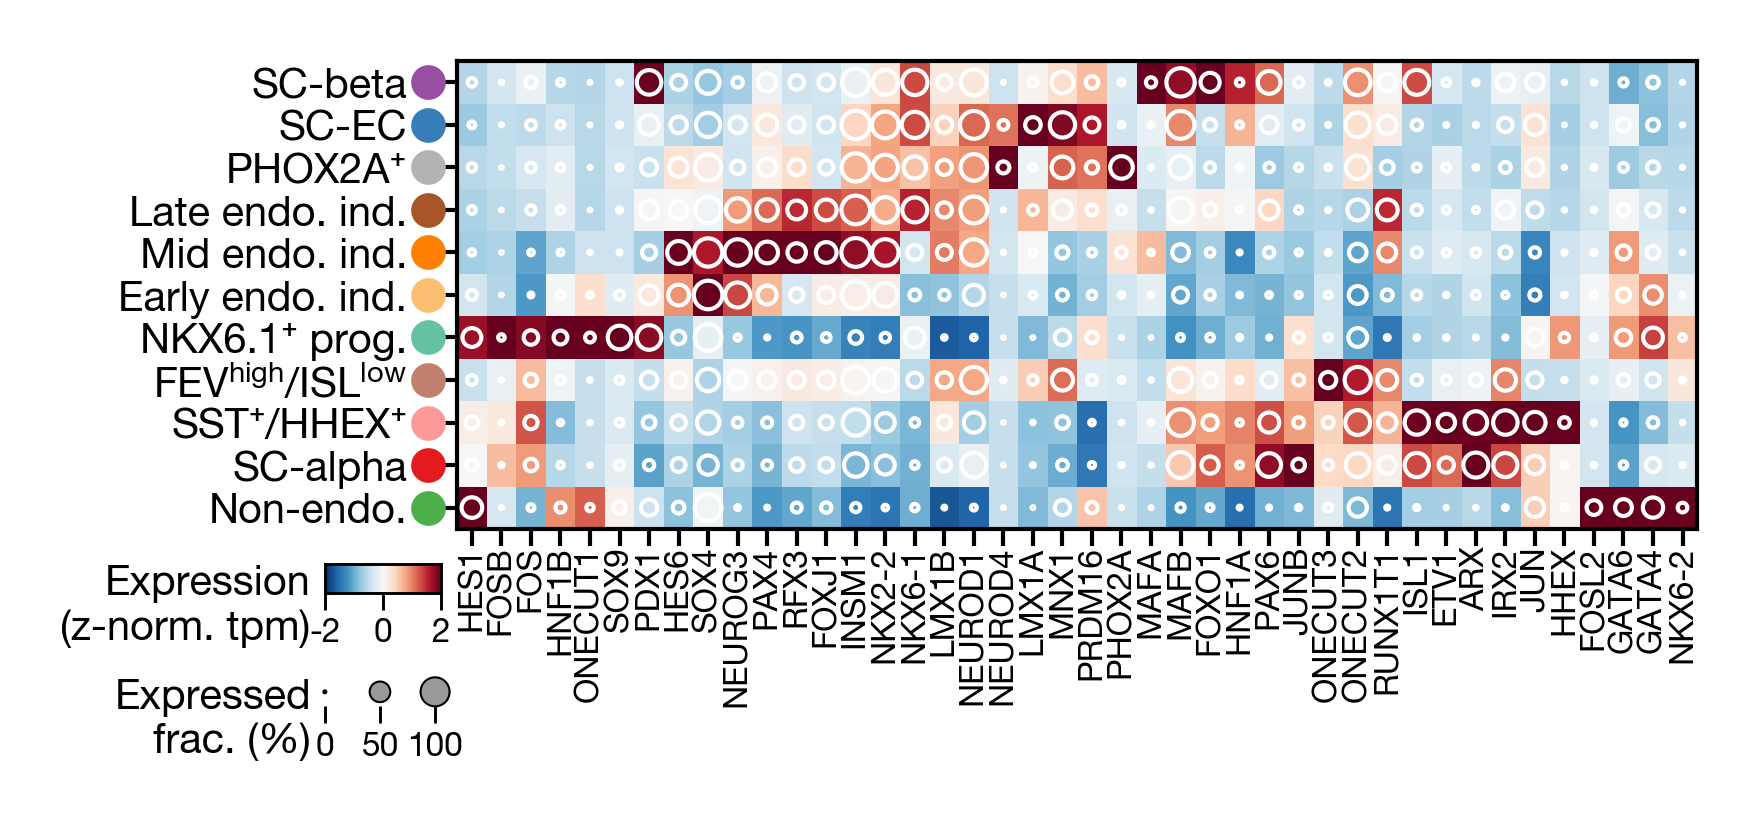

In [67]:
norm_tpm = cluster_tpm.copy()# + 1
norm_tpm -= norm_tpm.mean(0)
norm_tpm /= norm_tpm.std(0)
vmin, vmax = (-2, 2)

cmap = "RdBu_r"



_tpm = norm_tpm[sum(g_grp)].values
_frac = cluster_expr[sum(g_grp)].values

_y, _x = np.mgrid[:_tpm.shape[0], :_tpm.shape[1]]
_x = _x.ravel()
_y = _y.ravel()


###### Main plot
# 
#


fig_h = (30/mm_per_inch) 
fig_w = fig_h * (3.50/1.5)

fig = plt.figure(figsize=(fig_w, fig_h), dpi=600)

ax = fig.add_axes([0.24, 0.33, 0.75, 0.66],
              xscale='linear', yscale='linear',
            xlabel='', ylabel='', frameon=True)
ax.set_axisbelow(True)

ax.imshow(_tpm, aspect='auto',  cmap='RdBu_r', vmin=vmin, vmax=vmax)

# Draw fancy y tick labels
ax.set_yticks(range(len(cluster_order)))
tick_labels = []
for stg, cl in cluster_order:
    
    
    label_params = fv.dataset_label_params('stage5')
    tick_labels.append(f"{label_params[cl]['short_label']}")
ax.set_yticklabels(tick_labels)

ax.tick_params(axis='x', which='major', pad=0, width=0.5, zorder=-10, length=2)
ax.tick_params(axis='y', which='major', pad=4, width=0.5, zorder=-10, length=2)
for ci, (stg, cl) in enumerate(cluster_order):
    ax.scatter(-1.5, ci, s=10, clip_on=False, c=label_params[cl]['color'].reshape(1,-1))

# Draw data points
frac_symbol_size = 12
imax = ax.scatter(_x, _y, s=0.1 + _frac.ravel()*frac_symbol_size, c=_tpm.ravel(),
           linewidth=0.5, edgecolor='w',
#                   edgecolor=core_colors.grey,
           cmap=cmap, vmin=vmin, vmax=vmax, 
          )

# Fix plot limits
ax.set_xticks(range(len(sum(g_grp))))
ax.set_xticklabels(sum(g_grp), rotation=90, fontsize=4);
ax.set_xlim([-0.50, len(sum(g_grp))-0.5])
ax.set_ylim([-0.50, len(cluster_order)-0.5])

    
###### Colorbar
# 
#

with plt.rc_context(fv.thin_legend_params):
    colorbar_ax_position = [0.16, 0.24, 0.07, 0.04]
    colorbar_ax = fig.add_axes(colorbar_ax_position,
                    xscale='linear', yscale='linear', yticks=[],
                    xlabel='', ylabel='', frameon=True, )

    gradient = np.linspace(-2, 2, 256)
    gradient = np.vstack((gradient, gradient))
    colorbar_ax.imshow(gradient, aspect='auto', extent=(-2,2,0,1), 
                cmap=imax.cmap, vmin=vmin, vmax=vmax)
    colorbar_ax.tick_params(axis='y', which='major', length=0)

    xticks = np.linspace(-2, 2, 3).astype(int)
    colorbar_ax.set_xticks(xticks)
    colorbar_ax.set_xticklabels(xticks, fontsize=4);

    colorbar_ax.text(-2.5, 1, 'Expression\n(z-norm. tpm)', fontsize=5, ha='right', va='top');

    ###### Expression % legend
    # 
    #

    size_ax_position = [0.16, 0.08, 0.07, 0.04]
    size_ax = fig.add_axes(size_ax_position,
                    xscale='linear', yscale='linear', yticks=[], xticks=range(5),
                    xlabel='', ylabel='', frameon=False, )

    size_ax.scatter(np.linspace(-2,2,3), np.ones(3)*0.5, s=(np.linspace(0,1,3)+0.01)*frac_symbol_size, facecolor=core_colors.grey,
                    edgecolor='k',linewidth=0.25, clip_on=False)
    size_ax.set_xlim([-2,2.2])
    size_ax.set_xticks(np.linspace(-2,2,3))
    size_ax.tick_params(axis='y', which='major', pad=3,length=0)
    size_ax.set_xticklabels(['0',  '50', '100'], fontsize=4);
    size_ax.set_axisbelow(True)

    size_ax.set_ylim([0,1])
    size_ax.text(-2.5, 1, 'Expressed\nfrac. (%)', fontsize=5, ha='right', va='top');

fig.savefig('../../figures/components/main_figure5/GlobalHeatmap.pdf', dpi=600, transparent=True)



In [68]:
g_grp  = [
#FGF
['FGFR2','FGFR4','FGFR3','FGFRL1','FGFR1',],   
#EGF
['EGFR','ERBB3','ERBB2',],
#BMP
['BMP7','GDF7','BMP2','BMP4','SMAD9','GDF6','ACVR1',],
#Notch
 ['NOTCH3', 'NOTCH2', 'NOTCH1', 'JAG1', 'RBPJ', 'DLK1', 'DLL1', 'DLL3', 'CDKN1C', 'DLL4', 'PTF1A', 'HES1', ],
#Wnt
[ 'FZD8', 'FZD5', 'FRZB', 'FZD2', 'FZD7', 'SFRP5', 'FZD6', 'WNT9A', 'SFRP1', 'WNT4', 'FZD1', 'WLS',],
#Hippo
[ 'LATS2', 'YAP1', 'TEAD2', 'TEAD3',],
#Hedgehog
['SHH','GPC3','SMO','PTCH1','IHH','GPC4','GPC6',],
#Retinoic Acid Signaling
['CRABP2','STRA6','CRABP1','FABP5','RBP4','TTR','ALDH1A1'],
]

# ratio_order = ['scbeta', 'ph', 'ec', 'neurog3', 'sst',  'exo', 'other', 'repl']


cluster_order = [
    ('stage5.labels', 'scbeta'),
    ('stage5.labels', 'ec'),
    ('stage5.labels', 'phox2a'),
    ('stage5.labels', 'neurog3_late'),
    ('stage5.labels', 'neurog3_mid'),
    ('stage5.labels', 'neurog3_early'),
    ('stage5.labels', 'prog_nkx61'),
    ('stage5.labels', 'fev_high_isl_low'),
    ('stage5.labels', 'sst_hhex'),
    ('stage5.labels', 'ph'),
    ('stage5.labels', 'exo'),
][::-1]


cluster_tpm = utils.combine_rows(pb_tpm, cluster_order)
cluster_expr = utils.combine_rows(pb_expr, cluster_order)

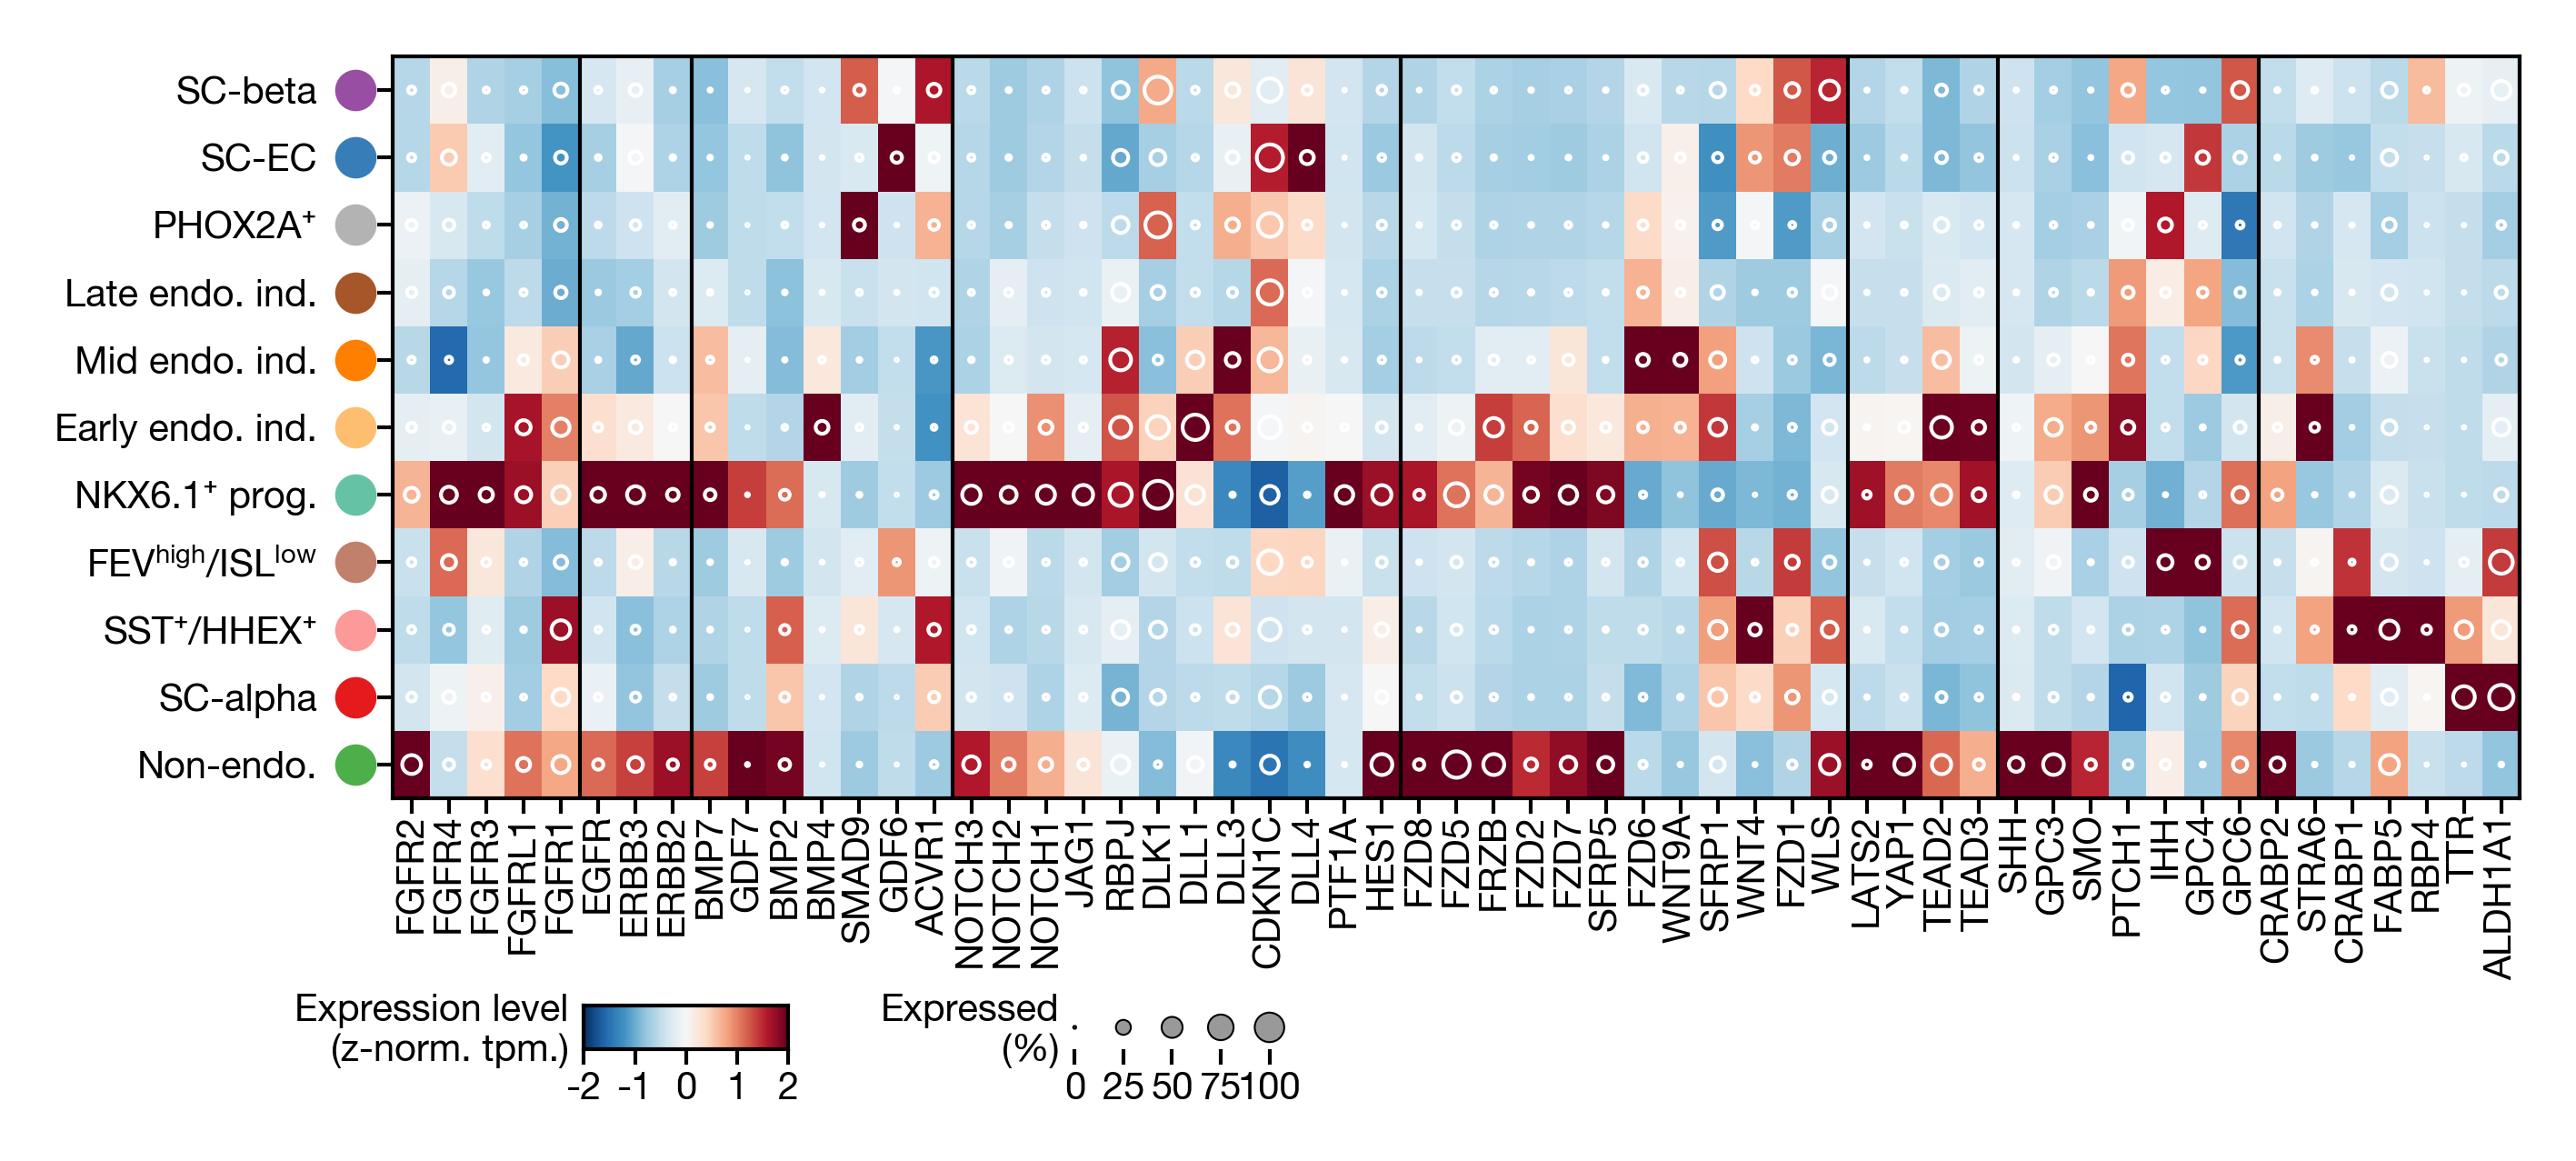

In [69]:
norm_tpm = cluster_tpm.copy()# + 1
norm_tpm -= norm_tpm.mean(0)
norm_tpm /= norm_tpm.std(0)
vmin, vmax = (-2, 2)
cmap = "RdBu_r"



_tpm = norm_tpm[sum(g_grp)].values
_frac = cluster_expr[sum(g_grp)].values

_y, _x = np.mgrid[:_tpm.shape[0], :_tpm.shape[1]]
_x = _x.ravel()
_y = _y.ravel()


###### Main plot
# 
#

fig = plt.figure(figsize=(5.,2), dpi=600)

ax = fig.add_axes([0.20, 0.30, 0.78, 0.68],
              xscale='linear', yscale='linear',
            xlabel='', ylabel='', frameon=True)
ax.set_axisbelow(True)

ax.imshow(_tpm, aspect='auto',  cmap='RdBu_r', vmin=vmin, vmax=vmax)

# Draw fancy y tick labels
ax.set_yticks(range(len(cluster_order)))
tick_labels = []
for stg, cl in cluster_order:
    
    
    label_params = fv.dataset_label_params('stage5')
    tick_labels.append(f"{label_params[cl]['short_label']}")
ax.set_yticklabels(tick_labels)

ax.tick_params(axis='x', which='major', pad=0, width=0.5, zorder=-10, length=2)
ax.tick_params(axis='y', which='major', pad=8, width=0.5, zorder=-10, length=2)
for ci, (stg, cl) in enumerate(cluster_order):
    ax.scatter(-1.5, ci, s=20, clip_on=False, c=label_params[cl]['color'].reshape(1,-1))

# Draw data points
size_mul = 15
imax = ax.scatter(_x, _y, s=0.1 + _frac.ravel()*size_mul, c=_tpm.ravel(),
           linewidth=0.5, edgecolor='w',
#                   edgecolor=core_colors.grey,
           cmap=cmap, vmin=vmin, vmax=vmax, 
          )

# Fix plot limits
ax.set_xticks(range(len(sum(g_grp))))
ax.set_xticklabels(sum(g_grp), rotation=90, fontsize=5);
ax.set_xlim([-0.50, len(sum(g_grp))-0.5])
ax.set_ylim([-0.50, len(cluster_order)-0.5])

# ax.tick_params(axis='both', which='major', pad=1, width=0.5, zorder=-10, length=2)
    
###### Colorbar
# 
#

colorbar_ax_position = [0.27, 0.07, 0.075, 0.04]
colorbar_ax = fig.add_axes(colorbar_ax_position,
                xscale='linear', yscale='linear', yticks=[0.5],
                xlabel='', ylabel='', frameon=True, )

gradient = np.linspace(-2, 2, 256)
gradient = np.vstack((gradient, gradient))
colorbar_ax.imshow(gradient, aspect='auto', extent=(-2,2,0,1), 
            cmap=imax.cmap, vmin=vmin, vmax=vmax)
colorbar_ax.tick_params(axis='y', which='major', pad=2, width=0.5, zorder=-10, length=0)

xticks = np.linspace(-2, 2, 5).astype(int)
colorbar_ax.set_xticks(xticks)
colorbar_ax.set_xticklabels(xticks, fontsize=5);

colorbar_ax.set_yticklabels(['Expression level\n(z-norm. tpm.)'], fontsize=5);

###### Expression % legend
# 
#

size_ax_position = [0.45, 0.07, 0.075, 0.04]
size_ax = fig.add_axes(size_ax_position,
                xscale='linear', yscale='linear', yticks=[0], xticks=range(5),
                xlabel='', ylabel='', frameon=False, )

size_ax.scatter(range(5), np.zeros(5), s=(np.linspace(0,1,5)+0.01)*size_mul, facecolor=core_colors.grey,
                edgecolor='k',linewidth=0.25, clip_on=False)
size_ax.set_xlim([0,4.2])
size_ax.tick_params(axis='y', which='major', pad=2, width=0.5, zorder=-10, length=0)
size_ax.set_xticklabels(['0', '25', '50', '75', '100'], fontsize=5);

size_ax.set_yticklabels(['Expressed\n(%)'], fontsize=5);

ccc = 0
for gs in g_grp:
    ccc += len(gs)
    ax.axvline(ccc-0.5, linewidth=0.5, c='k')
    
    
fig.savefig('../../figures/components/extended_figure8/ExtendedFigure8F.pdf', dpi=600, transparent=True)



In [17]:
utils.preload_ds_vals(d0_ds)
utils.preload_ds_vals(d1_ds)

In [18]:
dy_norm = {}
for dy,_ds in [(0, d0_ds), (1, d1_ds)]:
    dy_norm[dy] = cgm.CountsNormalizer(normalize_variance=False, mean_center=False)
    dy_norm[dy].fit(_ds.vals)

# (extended) tSNE marker genes

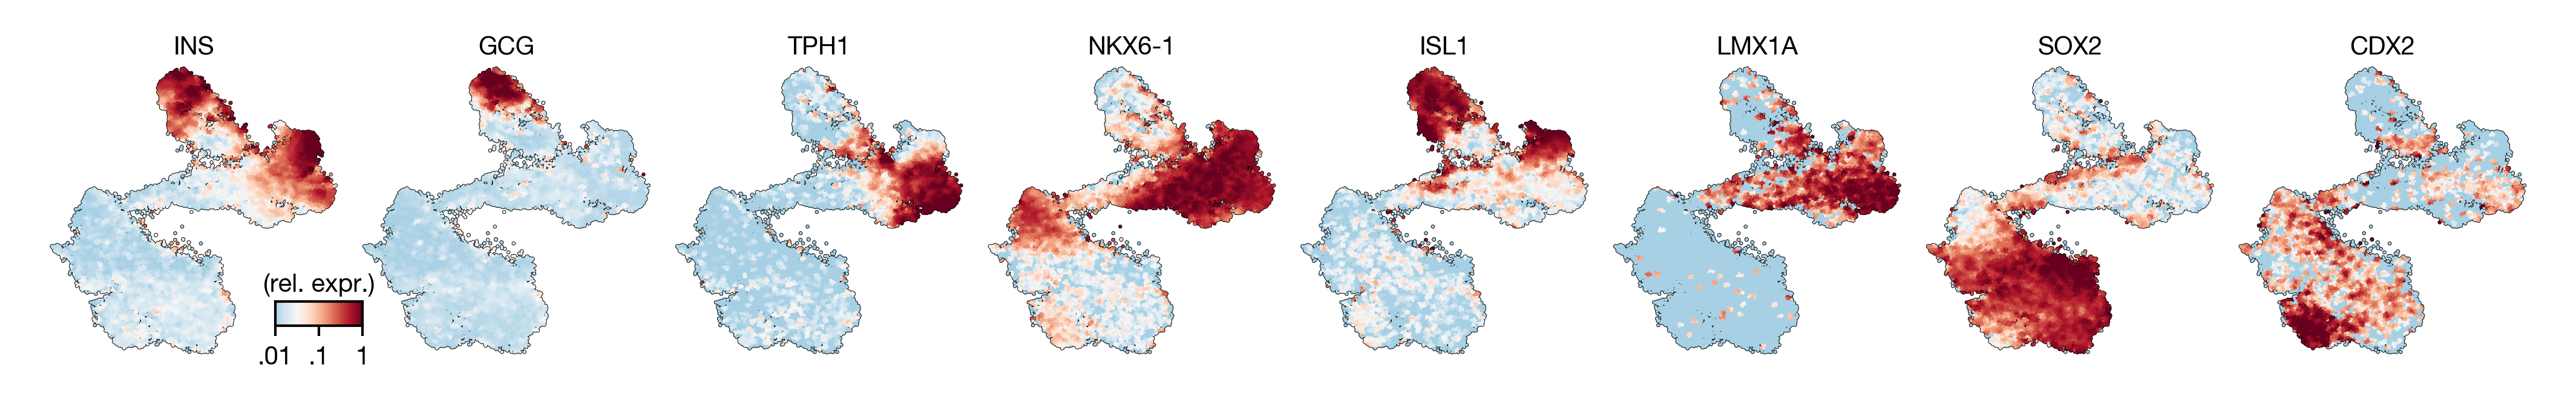

In [16]:
# importlib.reload(fv)# _ds = tds[s]
tsne_proj = ds.ca['TSNE']
    
vmin, vmax = -3, 0

fig_w = 175/mm_per_inch

fig = plt.figure(figsize=(fig_w, (fig_w/8) * 1.10), dpi=600)

gs = gridspec.GridSpec(2, 8, fig, 0,0,1,1, hspace=0, wspace=0,
                       height_ratios=[0.1, 1])

sm_display_s = 0.3
sm_outline_s = 0.6

###### Draw the labels
# 
#

for ci,g in enumerate(['INS', 'GCG', 'TPH1', 'NKX6-1', 'ISL1', 'LMX1A', 'SOX2', 'CDX2']):
   

    ax = fig.add_subplot(gs[1, ci], xticks=[], yticks=[],
                  xscale='linear', yscale='linear',
                  frameon=False,  zorder=-1)
    ax.set_title(g, pad=0)
    ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c='k', edgecolor='none',
               s=sm_outline_s, cmap='RdBu_r',
               rasterized=True)

    imax = ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c=regressed_expr_values[g], edgecolor='none',
               s=sm_display_s, cmap='RdBu_r', vmin=vmin, vmax=vmax,
               rasterized=True)
    ax.patch.set_visible(False)


##### Draw the labels
# 
#

cvmin = -2
cvmax = 0
colorbar_ax_position = [0.095, 0.12, 0.035, 0.07]
colorbar_ax = fig.add_axes(colorbar_ax_position,
                xscale='linear', yscale='linear', yticks=[],
                xlabel='', ylabel='', frameon=True, )

gradient = np.linspace(cvmin, cvmax, 256)
gradient = np.vstack((gradient, gradient))
colorbar_ax.imshow(gradient, aspect='auto', extent=(cvmin,cvmax,0,1), 
            cmap=imax.cmap, vmin=vmin, vmax=vmax)
colorbar_ax.tick_params(axis='both', which='major', pad=2, width=0.5, zorder=-10, length=2)

xticks = np.linspace(cvmin, cvmax, 5).astype(int)
colorbar_ax.set_xticks([-2, -1, 0])
colorbar_ax.set_xticklabels(['.01', '.1', '1'], fontsize=5);

colorbar_ax.set_title('(rel. expr.)', fontsize=5, pad=2);


fig.savefig('../../figures/components/extended_figure8/ExtendedFigure8B.pdf', transparent=True, dpi=600)


# (extended) tSNE, by single days

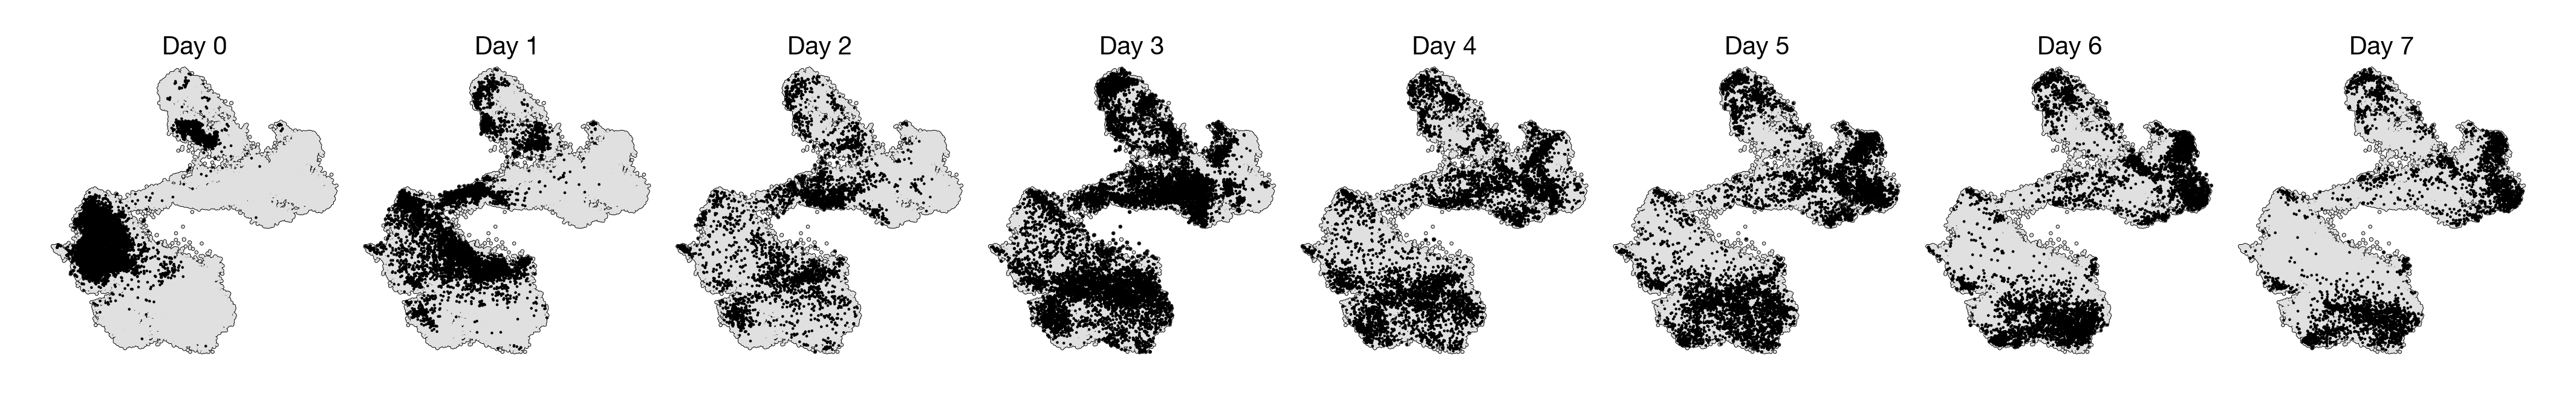

In [43]:
# importlib.reload(fv)# _ds = tds[s]
tsne_proj = ds.ca['TSNE']
    
vmin, vmax = -3, 0
fig_w = 175/mm_per_inch
fig = plt.figure(figsize=(fig_w, (fig_w/8) * 1.10), dpi=600)

gs = gridspec.GridSpec(2, 8, fig, 0,0,1,1, hspace=0, wspace=0,
                       height_ratios=[0.1, 1])

sm_display_s = 0.3
sm_outline_s = 0.6

###### Draw the labels
# 
#

for dy in range(8):
    ci = dy
    ax = fig.add_subplot(gs[1, ci], xticks=[], yticks=[],
                  xscale='linear', yscale='linear',
                  frameon=False,  zorder=-1)
    ax.set_title(f'Day {dy}', pad=0)
    ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c='k', edgecolor='none',
               s=sm_outline_s, cmap='RdBu_r',
               rasterized=True)
    
    ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c='#e0e0e0', edgecolor='none',
               s=sm_display_s, cmap='RdBu_r', vmin=vmin, vmax=vmax,
               rasterized=True)
    
    cell_day_filter = ds.ca.CellDay==dy
    
    imax = ax.scatter(tsne_proj[cell_day_filter, 0], tsne_proj[cell_day_filter, 1], c='k', edgecolor='none',
               s=sm_display_s, cmap='RdBu_r', vmin=vmin, vmax=vmax,
               rasterized=True)
    ax.patch.set_visible(False)


##### Draw the labels
# 
#


fig.savefig('../../figures/components/extended_figure8/ExtendedFigure8A.pdf', transparent=True, dpi=600)


In [70]:
teal_or = ['#66c2a5','#86c29d','#9fc296','#b4c28e','#c7c287','#dbc17f','#ecc077','#fdbf6f']
gr_tl = ['#347532','#3d8145','#468e57','#4f9b6a','#57a87e','#5eb591','#66c2a5']

teal_or = ['#dff2eb','#ebe5cd','#f3d8ad','#f9cc8e','#fdbf6f']
gr_tl = ['#4daf4a','#61bd8b','#7dcbb1','#9ed7c3','#bfe5d7','#dff2eb']

teal_or =  ['#c8e9dc','#dbdec0','#e9d4a6','#f4ca8a','#fdbf6f']
gr_tl = ['#4daf4a','#5fbb82','#72c7ab','#90d2bb','#adddcc','#c8e9dc']
import struct
from matplotlib.colors import LinearSegmentedColormap

def cdict_from_color_list(html_color_list, step_start=0, step_end=1):
    rgb_list = [struct.unpack('BBB',bytes.fromhex(s[1:])) for s in html_color_list]
    #   Are you using Python 2, then I think you need:
    #   rgb_list = [tuple(map(ord, s[1:].decode('hex'))) for s in html_color_list]
    
    cdict = {'red': [], 'green': [], 'blue': []}
    
    step_range = step_end - step_start
    for i, rgb in enumerate(rgb_list):
        step = step_start + step_range*(float(i)/(len(rgb_list) - 1))
        for color, value in zip(('red','green','blue'), rgb):
            cdict[color].append((step, value/255., value/255.))
    return cdict
            
def cmap_from_cdict(cdict):
    for color in ('red','green','blue'):
        cdict[color] = tuple(cdict[color])
            
    return LinearSegmentedColormap('Test', cdict)


tx = 0.55
d1_seg1 = cdict_from_color_list(gr_tl, 0, tx)
d1_seg2 = cdict_from_color_list(teal_or, tx, 1)

d1_cmap = {}
for color in ('red','green','blue'):
    d1_cmap[color] = d1_seg1[color] + d1_seg2[color]
    
d1_cmap = cmap_from_cdict(d1_cmap)
d0_cmap = cmap_from_cdict(cdict_from_color_list(gr_tl, 0, 1))




In [71]:
_d_cmaps = {
    0 : d0_cmap, 
    1 : d1_cmap,
}

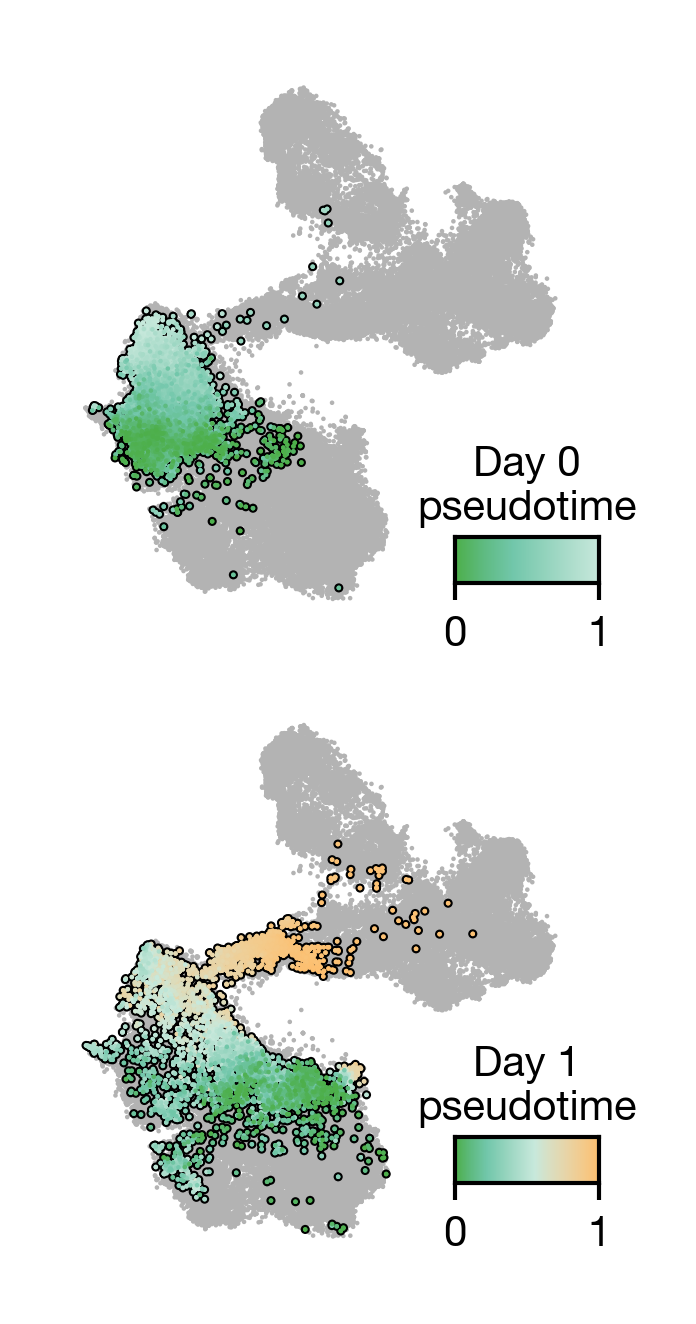

In [15]:
fig_w = 175/mm_per_inch
fig = plt.figure(figsize=((fig_w/8)*1.2, 2), dpi=600)

gs = gridspec.GridSpec(3, 2, fig, 0, 0, 1, 1,
                       hspace=0, wspace=0,
                       width_ratios=[1, 0.2],
                       height_ratios=[7.5/8, 1/8, 7.5/8],
                      )

# Draw the labels.
for dy,_ds,pi in [(0, d0_ds, 0), (1, d1_ds, 2)]:
    ax = fig.add_subplot(gs[pi, 0],
              xscale='linear', yscale='linear',
              frameon=False,
                xticks=[], yticks=[],
                        )
    
    _cells = np.where(np.isin(ds.ca.CellID, list(_ds.ca.CellID)))[0]
    _pdt = 1 - _ds.ca.PseudotimeRank
    sub_tsne_proj = tsne_proj[_cells]
    
#     ax = fig.add_subplot(gs[0, 1], xticks=[], yticks=[],
#               xscale='linear', yscale='linear',
#               frameon=False,  zorder=-1)

    ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c=core_colors.light_grey.reshape(1, -1), edgecolor='none',
               s=0.3,
               rasterized=True)

    ax.scatter(sub_tsne_proj[:, 0], sub_tsne_proj[:, 1], c='k', edgecolor='none',
               s=1.2,
               rasterized=True)

    co_ = np.argsort(-np.abs(_pdt))
    
    im_params = dict(edgecolor='none',
           cmap = _d_cmaps[dy],
           vmin=0, vmax=1,
           rasterized=True)
    
    
    im = ax.scatter(sub_tsne_proj[:, 0][co_], sub_tsne_proj[:, 1][co_], c=_pdt[co_],
                    s=0.3,  **im_params)
    
    
    im = ax.scatter(sub_tsne_proj[:, 0][co_], sub_tsne_proj[:, 1][co_], c=_pdt[co_],
                    s=0.3,  **im_params)
    
    
    cvmin = -2
    cvmax = 0
    colorbar_ax_position = [7.5 * 0.095 / ((7.5/8)*1.2),
                            1.1 * 0.12 / 2 + (0.5 if dy==0 else 0),
                            0.035 * 7.5 /((7.5/8)*1.2),
                            0.07/2 * 1.10]
    colorbar_ax = fig.add_axes(colorbar_ax_position,
                    xscale='linear', yscale='linear', yticks=[],
                    xlabel='', ylabel='', frameon=True, )

    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    colorbar_ax.imshow(gradient, aspect='auto', extent=(0,1,0,1), 
                cmap=im.cmap, vmin=0, vmax=1)
    colorbar_ax.tick_params(axis='both', which='major', pad=2, width=0.5, zorder=-10, length=2)

    xticks = np.linspace(cvmin, cvmax, 5).astype(int)
    colorbar_ax.set_xticks([0, 1])
    colorbar_ax.set_xticklabels([0, 1], fontsize=5);

    colorbar_ax.set_title(f'Day {dy}\npseudotime', fontsize=5, pad=2);


fig.savefig('../../figures/components/extended_figure8/ExtendedDataFigure8C.pdf', transparent=True, dpi=600)

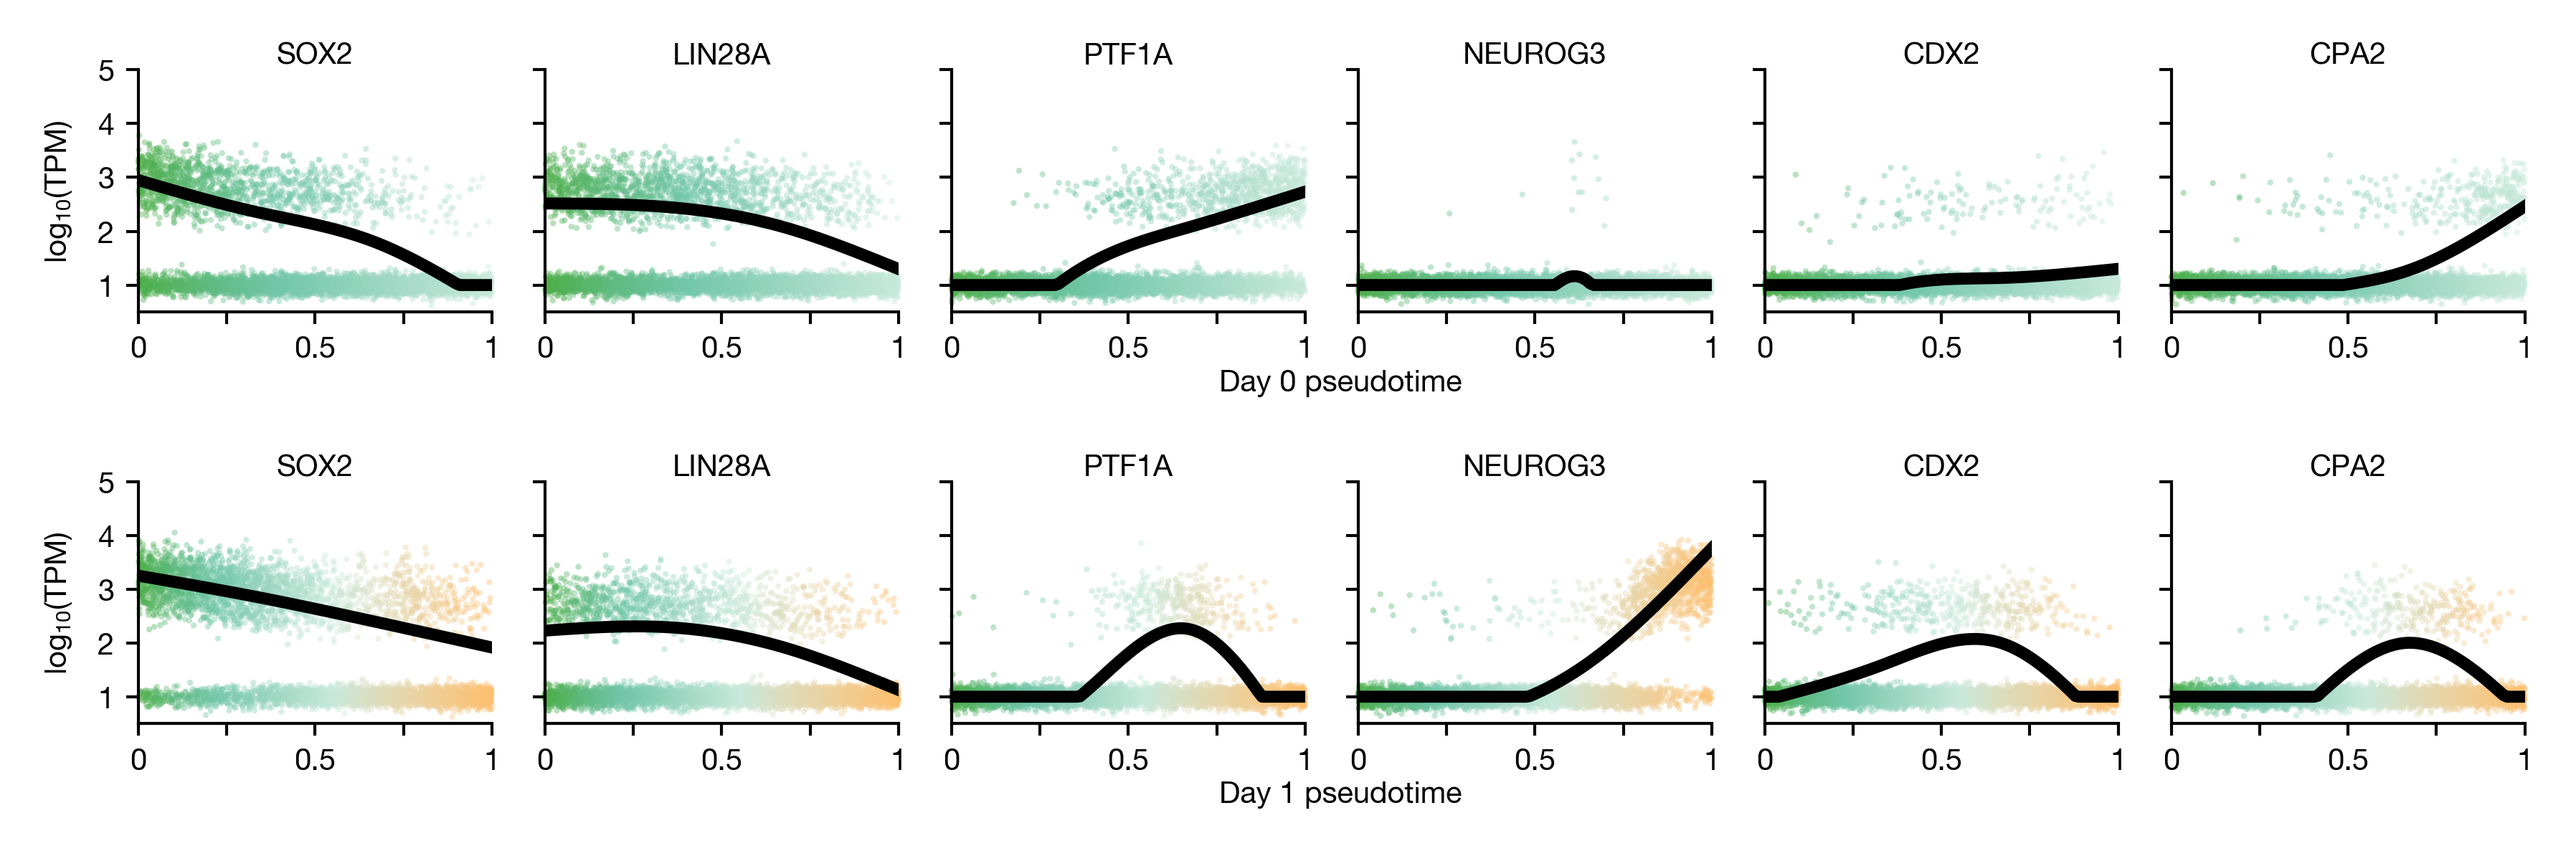

In [72]:

fig_w = (175/mm_per_inch)*(7/8)

fig = plt.figure(figsize=(fig_w, 2), dpi=600)

gs = gridspec.GridSpec(2, 6, fig, 0.07, 0.17, 0.99,0.93,
                       hspace=0.7, wspace=0.15,
#                        width_ratios=
#                        height_ratios=[1,3],
                      )

for ci, g in enumerate(['SOX2', 'LIN28A' , 'PTF1A',  'NEUROG3', 'CDX2', 'CPA2']):
    
    for dy,_ds in [(0, d0_ds), (1, d1_ds)]:
        ax = fig.add_subplot(gs[dy, ci],
                  xscale='linear', yscale='linear',
                  frameon=True,
                    xticks=[],
    #                          yticks=[],
                            )

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        gi = np.where(_ds.ra.Gene == g)[0]
        if len(gi) == 0:
            continue

        cell_pdt = 1 - _ds.ca.PseudotimeRank
        expr_pv = 0.1
        cell_expr = np.log10(dy_norm[dy].transform(_ds.vals, genes=gi) + expr_pv)

        np.random.seed(ci)
        cell_expr +=np.random.randn(*cell_expr.shape)/10

        fit_expr = np.log10(np.exp(_ds.ra.Pred__pseudotime[gi])).ravel()
        fit_expr[fit_expr < np.log10(expr_pv)] = np.log10(expr_pv)
        fit_domain = 1 - np.linspace(0, 1, len(fit_expr))

    #     x = dptime_scaled
    #     y = log_tpm[g][x.index]

        ax.scatter(cell_pdt, cell_expr, c=cell_pdt, marker='.', s=4,
                   edgecolor='none', alpha=0.4, 
                   clip_on=False,
                   cmap = _d_cmaps[dy],
           vmin=0, vmax=1,
                   rasterized=True)

        ax.plot(fit_domain, fit_expr, linewidth=2, c='k', clip_on=True,)
        

        ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
        ax.set_xticklabels([])
        ax.set_yticks([-1, 0,1,2,3])
        if ax.is_first_col():
            ax.set_yticklabels([1, 2, 3, 4, 5])
            ax.set_ylabel(r'log$_{10}$(TPM)')
        else:
            ax.set_yticklabels([])

        ax.set_title(g, pad=1)
        if ax.is_first_row():
            if ci==2:
                ax.set_xlabel('Day 0 pseudotime', labelpad=1, position=(1.1, 1))
            
        elif ax.is_last_row():
            if ci==2:
                ax.set_xlabel('Day 1 pseudotime', labelpad=1, position=(1.1, 1))
#                 ax.xaxis.set_label_position("right")
            
        ax.set_xticklabels([0, '', '0.5', '', '1'])
        ax.tick_params(axis='both', which='major', pad=2, width=0.5, zorder=-10, length=2)
        ax.set_ylim([-1.5,3])
        ax.set_xlim([0, 1])
        


fig.savefig('../../figures/components/extended_figure8/ExtendedFigure8D.pdf', transparent=True, dpi=600)

In [20]:
# importlib.reload(pseudotime)

from scbeta_scrnaseq import pseudotime
pseudotime.annotate_vgam_ds(d0_ds, pv = 0.1, n_smooth=5)

_r = np.where(d0_ds.ra['_Regressed'])[0]

time_var = pd.Series(d0_ds.ra['Pred__pseudotime__log2fc__min_max'], index=pdt_ds.ra.Gene).fillna(.0)

time_fc = -pd.Series(d0_ds.ra['Pred__pseudotime__log2fc__start_end'], index=pdt_ds.ra.Gene).fillna(.0)
time_qval = pd.Series(d0_ds.ra['LRT_Pseudotime_qval'], index=pdt_ds.ra.Gene).fillna(1.0)


NameError: name 'pdt_ds' is not defined

In [ ]:

nkx_genes = ['CPA2', 'NOTCH1', 'PDX1', 'CADPS', 'SERPINA1', 'GFRA3', 'SPINK1',
       'SLIT3', 'HEY1', 'GATM', 'PTF1A', 'LEFTY1', 'TTYH1', 'NKX6-1', 'DLK1']

sox_genes = ['SOX21', 'SOX2', 'GDF15', 'CLDN18', 'PTPN13', 'GPC3', 'PAM', 
       'CALB1',  'LIN28A','RIPPLY3','BBC3','CDKN1A', 'CRMP1',  'CROT', 'FRZB', ]


In [ ]:


import matplotlib.patheffects as PathEffects

fig = plt.figure(figsize=(2.0, 2.3), dpi=600)

gs = gridspec.GridSpec(1, 1, fig, 0.14, 0.12, 0.75,0.97,
                       hspace=0.1, wspace=0,
#                        width_ratios=[0.5, 2]+[0.1]*6,
#                        height_ratios=[1,2],
                      )

y = time_fc
x = -np.log10(time_qval + 10**-150)

# Draw the labels.
ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=True,
#             xticks=[], yticks=[],
                    )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel(r'pseudotime model fit, -log$_{10}$(q-value)', fontsize=5, labelpad=2)
ax.set_ylabel(r'fold-change, log$_2$', fontsize=5, labelpad=2)

# x = pd.Series(pdt_ds.ra['Pred__pseudotime__log2fc__start_end'][_reg], index=scb_ds.ra.Gene[_reg])
# y = pd.Series(-np.log10(pdt_ds.ra['LRT_Pseudotime_qval'][_reg]), index=scb_ds.ra.Gene[_reg])


clip__grp = (x > 90)
sc_attrs = dict(c='k', marker='.', edgecolor='none', s=5, alpha=0.3, rasterized=True)
ax.scatter(x[~clip__grp], y[~clip__grp], clip_on=True, **sc_attrs)
ax.scatter(x[clip__grp], y[clip__grp], clip_on=False, **sc_attrs)

gene_label_fontsize = 5
white_path_effect = [PathEffects.withStroke(linewidth=0.5, foreground='w')]

g_label_spacing = 0.45

txt_pos = 162
line_pos = 160
notch_pos = 155
xlims = [0, 150]


em_genes = nkx_genes

em_col = core_colors.teal
_ng = len(em_genes)
em_locs = 6.9 - (_ng - np.arange(_ng) - 1)*g_label_spacing


ax.scatter(x[em_genes],y[em_genes], color=em_col, edgecolor='none', s=4, clip_on=False)
for gi,g in enumerate(em_genes):
    g_loc = em_locs[gi]
    ax.text(txt_pos, g_loc, g, fontsize=5, ha='left', va='center', color=em_col)
    ax.plot([x[g], notch_pos, line_pos], [y[g], g_loc, g_loc], clip_on=False, lw=0.5, alpha=0.5, color=em_col)

    
em_genes = sox_genes
# em_genes = y[em_genes].sort_values().index
em_col = core_colors.green
_ng = len(em_genes)
em_locs = -6.9 + (np.arange(_ng))*g_label_spacing

ax.scatter(x[em_genes],y[em_genes], color=em_col, edgecolor='none', s=4, clip_on=False)
for gi,g in enumerate(em_genes):
    g_loc = em_locs[gi]
    ax.text(txt_pos, g_loc, g, fontsize=5, ha='left', va='center', color=em_col)
    ax.plot([x[g], notch_pos, line_pos], [y[g], g_loc, g_loc], clip_on=False, lw=0.5, alpha=0.5, color=em_col)

    
       
    
ylims = (-7, 7)

ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_yticks([-7,-5,-3,-2,0,2,3,5,7])

qval_thr = 3
fc_thr = np.log2(4)
ax.plot([qval_thr, qval_thr, xlims[1]], [ylims[0], -fc_thr, -fc_thr], '--', linewidth=0.5, color=core_colors.green)
ax.plot([qval_thr, qval_thr, xlims[1]], [ylims[1], fc_thr, fc_thr], '--', linewidth=0.5,color=core_colors.teal)

n_beta = sum((y > fc_thr) & (x > qval_thr))
n_ec = sum((y < -fc_thr) & (x > qval_thr))
ax.text(5, 6.9 , f'{n_beta} NKX6.1$^+$ prog. genes', ha='left', va='top', fontsize=5, color=core_colors.teal)
ax.text(5, -6.9, f'{n_ec} SOX2$^+$ prog. genes', ha='left', va='bottom', fontsize=5, color=core_colors.green)

ax.tick_params(axis='both', which='major', pad=2, width=0.5, zorder=-10, length=2)

fig.savefig('../../figures/components/extended_figure8/ExtendedFigure8E.pdf', dpi=600)


